In [1]:
# graphical representation of amazon rules

In [2]:
from rbbm_src.labelling_func_src.src.example_tree_rules import (
gen_amazon_funcs,
gen_gpt_refined_amazon_funcs_user_input_20
)

In [3]:
import pydot
from IPython.display import Image, display

In [4]:
amazon_trees = gen_amazon_funcs()

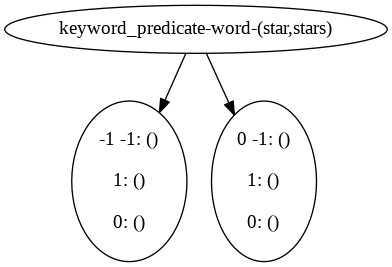

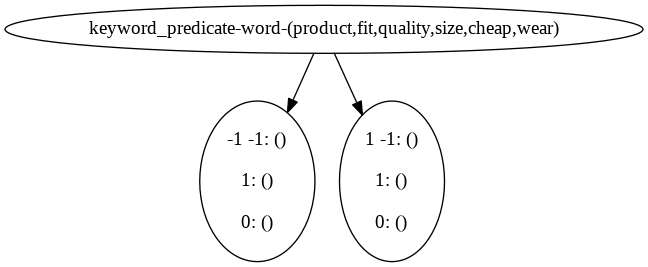

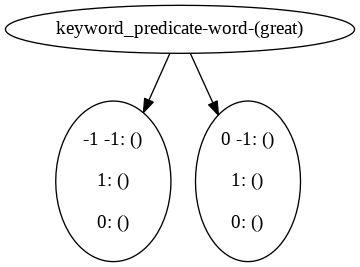

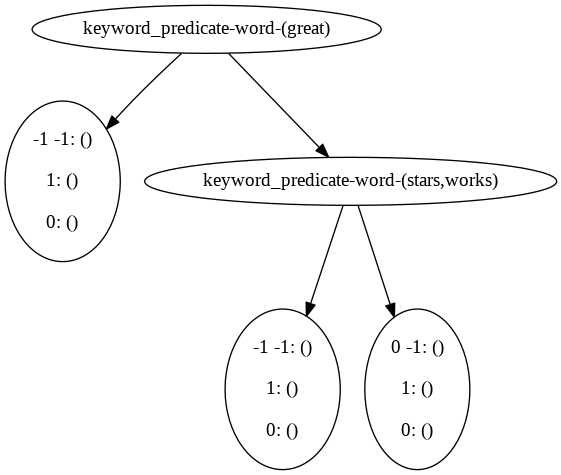

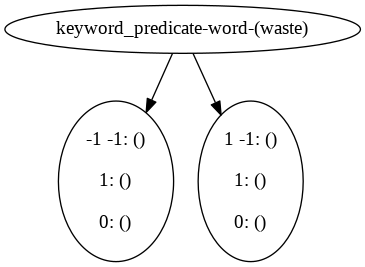

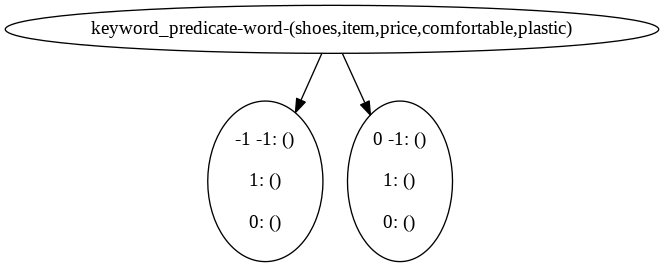

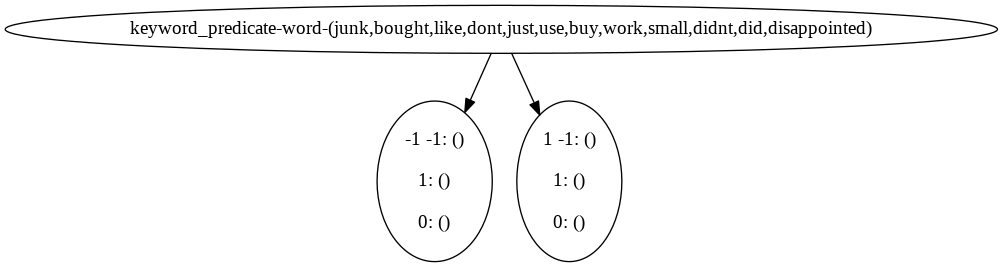

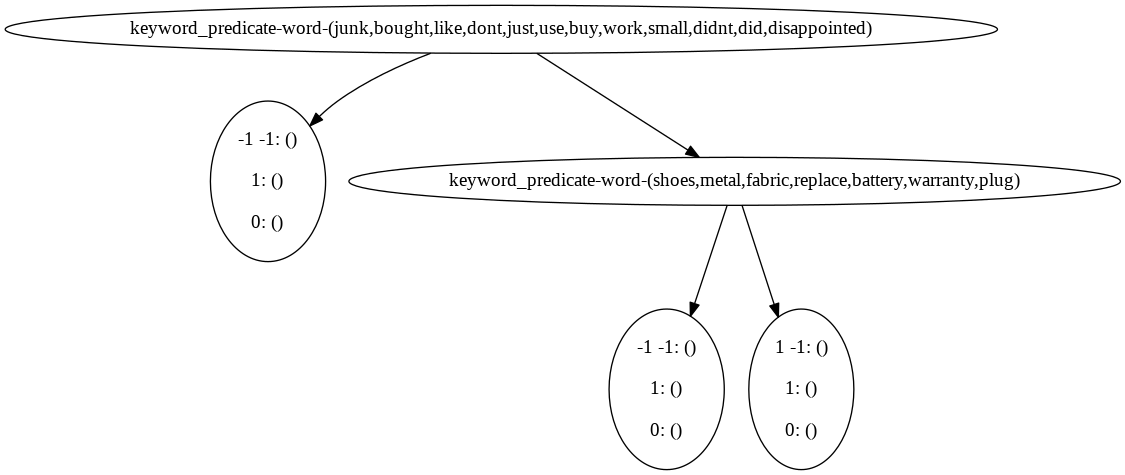

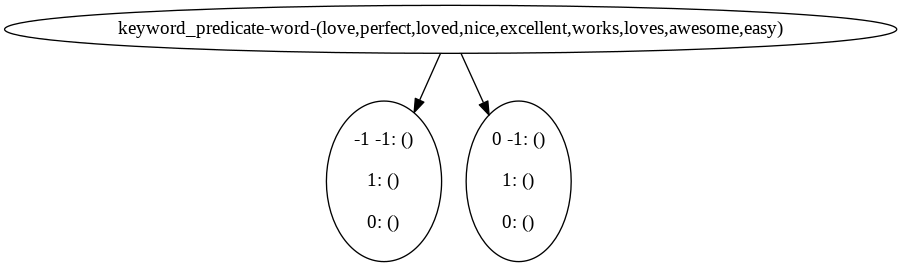

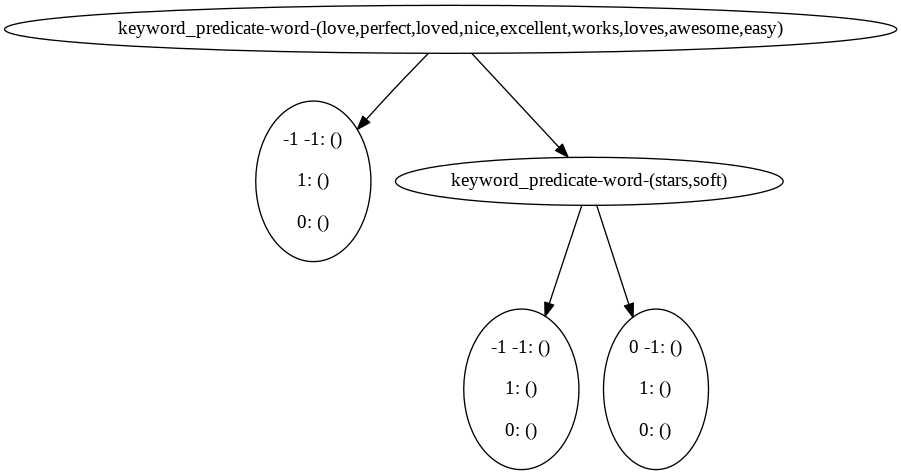

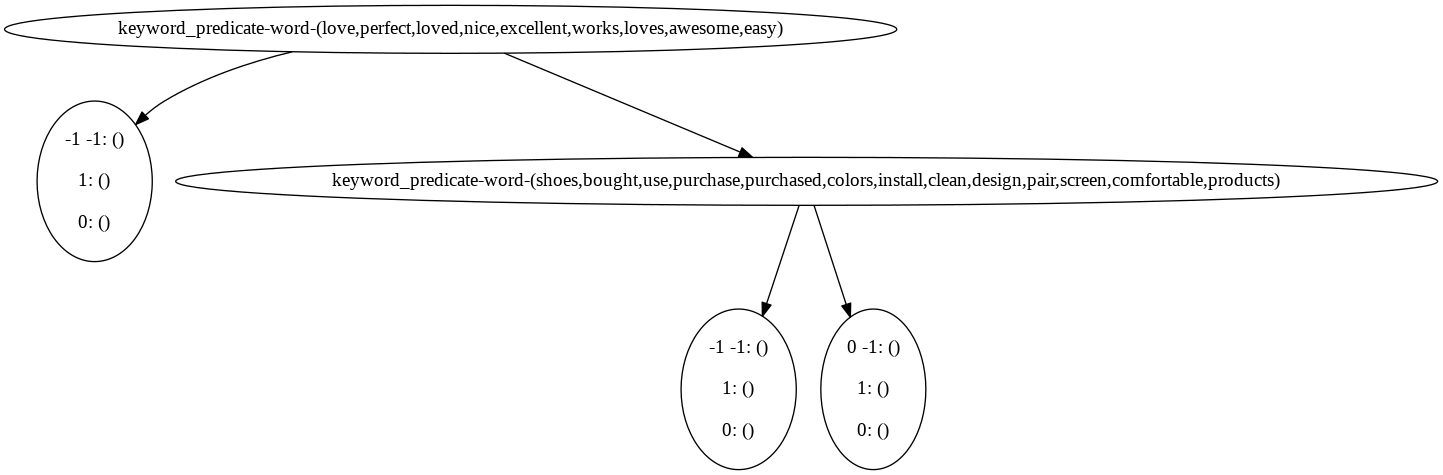

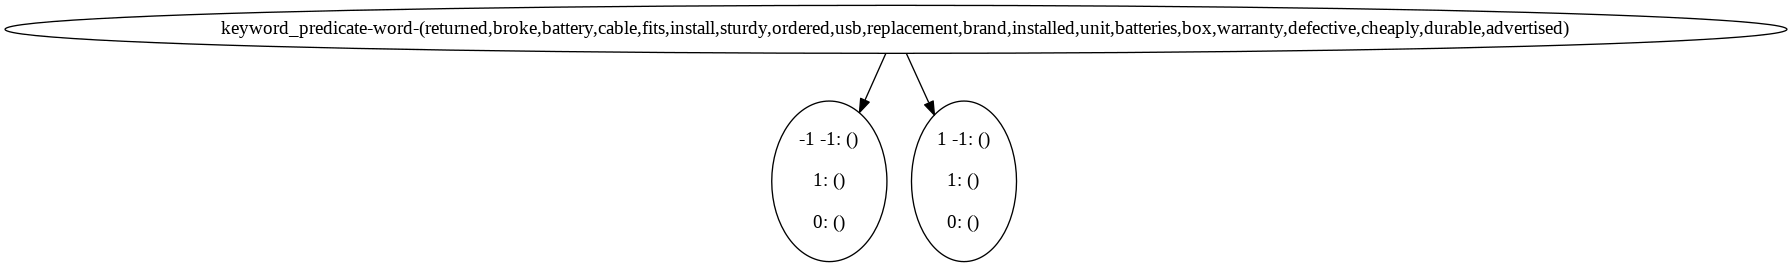

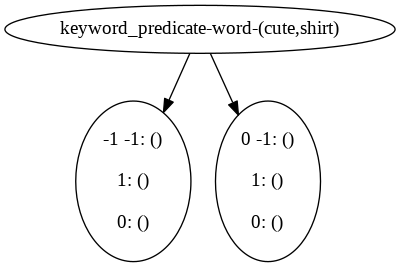

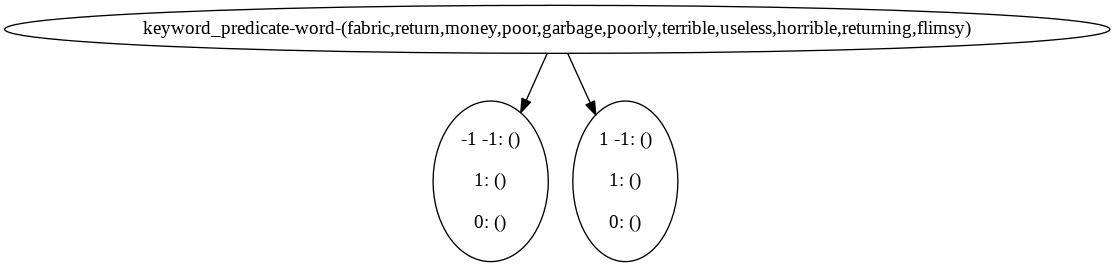

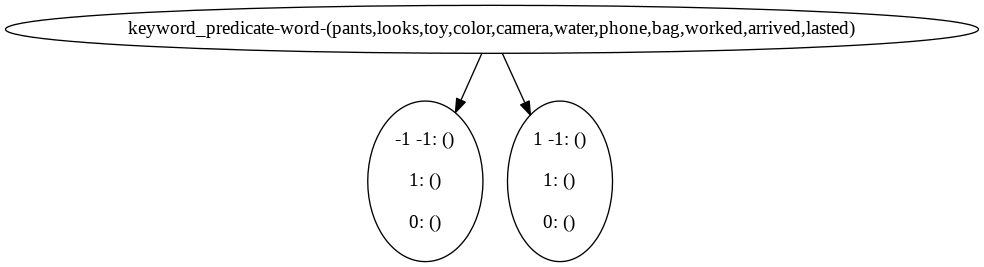

In [5]:
for at in amazon_trees:
    dot_string = at.gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [6]:
# get the user input 

# from rbbm_src.labelling_func_src.src.utils import lf_constraint_solve
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM, ABSTAIN, PredicateNode
from rbbm_src.labelling_func_src.src.LFRepair import populate_violations, fix_rules_with_solver_input
from rbbm_src.labelling_func_src.src.classes import clean_text

import re
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
import pulp
from sklearn.metrics import accuracy_score, classification_report

from rbbm_src.labelling_func_src.src.KeyWordRuleMiner import KeyWordRuleMiner 
# sample user confirmation and complaints
import random
from collections import deque
import numpy as np
import pickle
import pydot
from IPython.display import Image, display 

import datetime

[nltk_data] Downloading package words to /home/opc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/opc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-10-17 21:19:19.763424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 21:19:19.844827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 21:19:19.846329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
DEBUG 2024-10-17 21:19:20,980 [tpu_cluster_resolver.py:<module>:32] Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install c

In [7]:
def run_snorkel_with_funcs(dataset_name, funcs, conn):
    
    sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
    sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
    sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
    sentences_df = sentences_df[~sentences_df['text'].isna()]
    applier = PandasLFApplier(lfs=funcs)
    initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
    model = LabelModel(cardinality=2, verbose=True, device='cpu')
    model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)
    probs_test= model.predict_proba(L=initial_vectors)
    df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal  = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
    )	

    df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
    prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
    prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
    df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
    df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
    df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

    wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]
    # df_sentences_filtered.to_csv('predictions_shakira.csv', index=False)
    # logger.critical(wrong_preds)
    global_accuray_on_valid=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

    print(f"""
        out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
        make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
        accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)
    
    global_accuracy = (len(df_sentences_filtered)-len(wrong_preds))/len(sentences_df)
    
    
    ground_truth = df_sentences_filtered['expected_label']
    snorkel_predictions = df_sentences_filtered['model_pred']
    snorkel_probs = df_sentences_filtered['model_pred_diff']
    df_sentences_filtered['vectors'] = pd.Series([",".join(map(str, t)) for t in filtered_vectors])
    correct_predictions = (snorkel_predictions == ground_truth)
    incorrect_predictions = (snorkel_predictions != ground_truth)
    correct_preds_by_snorkel = df_sentences_filtered[correct_predictions].reset_index(drop=True)
    wrong_preds_by_snorkel = df_sentences_filtered[incorrect_predictions].reset_index(drop=True)
    
    return df_sentences_filtered, correct_preds_by_snorkel, wrong_preds_by_snorkel, filtered_vectors, correct_predictions, incorrect_predictions, global_accuracy, global_accuray_on_valid 

In [8]:
def select_user_input(user_confirm_size,
                     user_complaint_size,
                     random_state,
                     filtered_vectors,
                     correct_preds_by_snorkel,
                     wrong_preds_by_snorkel,
                      correct_predictions,
                      incorrect_predictions ):

    user_confirm_df = correct_preds_by_snorkel.sample(n=user_confirm_size, random_state=random_state)
    user_complaints_df = wrong_preds_by_snorkel.sample(n=user_complaint_size, random_state=random_state)
    
    random_confirm_indices = user_confirm_df.index
    random_complaints_indices = user_complaints_df.index
    random_user_confirms_vecs = filtered_vectors[correct_predictions][random_confirm_indices]
    random_user_complaints_vecs = filtered_vectors[incorrect_predictions][random_complaints_indices]
    user_input_df = pd.concat([user_confirm_df, user_complaints_df])
    gts = user_input_df['expected_label'].reset_index(drop=True)
    user_vecs = np.vstack((random_user_confirms_vecs, random_user_complaints_vecs))
    
    return user_vecs, gts, user_input_df


In [9]:
def gather_used_keywords(tree_rules):
    
    used_keywords = []
    
    for atui in tree_rules:
        rids = set([])
        queue = deque([atui.root])
        while(queue):
            cur_node = queue.popleft()
            if(isinstance(cur_node, PredicateNode)):
                used_keywords.extend(cur_node.pred.keywords)
            if(cur_node.left):
                queue.append(cur_node.left)
            if(cur_node.right):
                queue.append(cur_node.right)
    
    return used_keywords

In [10]:
def apply_new_lfs_to_df(new_funcs, user_input_df):
    new_rules_applier = PandasLFApplier(lfs=new_funcs)
    new_rules_vector = new_rules_applier.apply(df=user_input_df, progress_bar=False)
    
    return new_rules_vector

In [11]:
def construct_input_df_to_solver(user_vecs, gts):
    
#     df_new_vectors = pd.DataFrame(new_rules_vector, columns=[f'nlf_{i+1}' for i in range(new_rules_vector.shape[1])])
    df_user_vectors = pd.DataFrame(user_vecs, columns=[f'lf_{i+1}' for i in range(user_vecs.shape[1])])
    combined_df= pd.concat([df_user_vectors, gts], axis=1)
    
    return combined_df

In [12]:
def main_driver(user_input_size,
         lf_acc_thresh,
         instance_acc_thresh,
         min_non_abstain_thresh,
        dataset_name,
        random_state,
        funcs_dictionary,
       instance_acc_on_valid,
       use_non_abstain):
    
    
    run_times = ['snorkel_first_run','snorkel_run_after_fix', 'solver_runtime','repair_time']
    runtime_dict = {r:0 for r in run_times}

    gen_input_tree_rules_func = funcs_dictionary[dataset_name]
    
    conn = psycopg2.connect(dbname='label', user='postgres')
    
    user_complaint_size = math.floor(user_input_size * 0.5)
    user_confirm_size = user_input_size - user_complaint_size
     
    treerules_for_user_input = gen_input_tree_rules_func()
    
    treerules = gen_input_tree_rules_func()
    
    funcs = [f.gen_label_rule() for f in treerules]
    
    first_snorkel_run_start = time.time()
    df_sentences_filtered, correct_preds_by_snorkel, wrong_preds_by_snorkel, filtered_vectors, correct_predictions, incorrect_predictions, global_accuracy, global_accuracy_on_valid =run_snorkel_with_funcs(dataset_name=dataset_name, funcs=funcs, conn=conn)
    first_snorkel_run_end = time.time()
    first_snorkel_run_time = first_snorkel_run_end - first_snorkel_run_start
    runtime_dict['snorkel_first_run'] = first_snorkel_run_time

    user_vecs, gts, user_input_df = select_user_input(user_confirm_size, user_complaint_size, random_state,
                      filtered_vectors,correct_preds_by_snorkel,
                      wrong_preds_by_snorkel, correct_predictions, incorrect_predictions)

        
    combined_df = construct_input_df_to_solver(user_vecs, gts)
    
    return combined_df, user_input_df, global_accuracy

In [13]:
dataset_dict = {
#     "plots": gen_plots_funcs,
    "amazon": gen_amazon_funcs,
#     "dbpedia": gen_dbpedia_funcs,
#     "agnews": gen_agnews_funcs,
#     "physician_professor": gen_pp_funcs,
#     "imdb": gen_imdb_funcs,
#     "fakenews": gen_fakenews_funcs,
#     "yelp": gen_yelp_funcs,
#     "photographer_journalist": gen_pj_funcs,
#     "professor_teacher": gen_professor_teacher_funcs,
#     "painter_architect": gen_painter_architecht_funcs,
#     "tweets": gen_tweets_funcs,
#     "spam": gen_spam_funcs,
}

In [14]:
def run_main_with_params(user_input_size, lf_acc_thresh, instance_acc_thresh, 
                         min_non_abstain_thresh, random_state, dataset_name, funcs_dictionary,
                         instance_acc_on_valid,use_non_abstain):

    combined_df, user_input, global_accuracy = main_driver(
        user_input_size=user_input_size,
        lf_acc_thresh=lf_acc_thresh,
        instance_acc_thresh=instance_acc_thresh,
        min_non_abstain_thresh=min_non_abstain_thresh,
        random_state=random_state,
        dataset_name=dataset_name,
        funcs_dictionary=funcs_dictionary,
        instance_acc_on_valid=instance_acc_on_valid,
       use_non_abstain=use_non_abstain)
    
    print(f"global accuracy: {global_accuracy}")
    
    return user_input


In [15]:
def test_main_with_timeout(params_list, time_limit_minutes):
    time_limit_seconds = time_limit_minutes * 60
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for params in params_list:
            future = executor.submit(run_main_with_params, *params)
            try:
                result = future.result(timeout=time_limit_seconds)
                print(f"Params {params} finished successfully.")
                results.append(result)
            except concurrent.futures.TimeoutError:
                print(f"Params {params} exceeded the time limit, moving to the next set.")
    
    return results

In [16]:
user_input_sizes = [20]
random_states = [1]
lf_acc_threshs = [0.7]
instance_acc_threshs = [0.8]
non_abstain_threshs = [0.8]
datasets = list(dataset_dict)
func_dictionary = [dataset_dict]
instance_acc_on_valids=[True]
use_non_abstains=[True]


In [17]:
import itertools
import concurrent.futures
import time
import math

In [18]:
input_params = list(itertools.product(
    user_input_sizes,
    lf_acc_threshs,
    instance_acc_threshs,
    non_abstain_threshs,
    random_states,
    datasets,
    func_dictionary,
    instance_acc_on_valids,
    use_non_abstains
))


In [19]:
user_df = test_main_with_timeout(input_params, time_limit_minutes=20)

/tmp/ipykernel_12376/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:23:03,076 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:23:03,124 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 712.72epoch/s]
INFO 2024-10-17 21:23:03,832 [label_model.py:fit:977] Finished Training



        out of 199591 sentences, 188660 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 69628 wrong predictions, 

        accuracy = 0.6309339552634369 
    
global accuracy: 0.5963795962743811
Params (20, 0.7, 0.8, 0.8, 1, 'amazon', {'amazon': <function gen_amazon_funcs at 0x7fc3810324c0>}, True, True) finished successfully.


In [20]:
list(user_df[0])

['old_text',
 'expected_label',
 'fold',
 'cid',
 'text',
 'model_pred_diff',
 'model_pred_prob_tuple',
 'model_pred',
 'vectors']

In [21]:
gpt_cids = user_df[0]['cid'].to_list()

In [22]:
len(user_df)

1

In [23]:
import pickle

In [24]:
with open('Oct15_night_run/Oct-15-all-datasets-instance_acc_on_valid-use_non_abstain-amazon_sample_params_20-0.7-0.8-0.8-1-20241016_042104.pkl', 'rb') as f:
    rulecleaner_input = pickle.load(f)

In [25]:
rulecleaner_cids = rulecleaner_input['fix_details']['original_0']['user_input']['cid'].to_list()

In [26]:
len([x for x in gpt_cids if x not in rulecleaner_cids])

0

In [27]:
input_to_chatgpt = user_df[0][['text','expected_label']]

In [28]:
input_to_chatgpt.to_csv('chatgpt_amazon_userinput.csv', index=False)

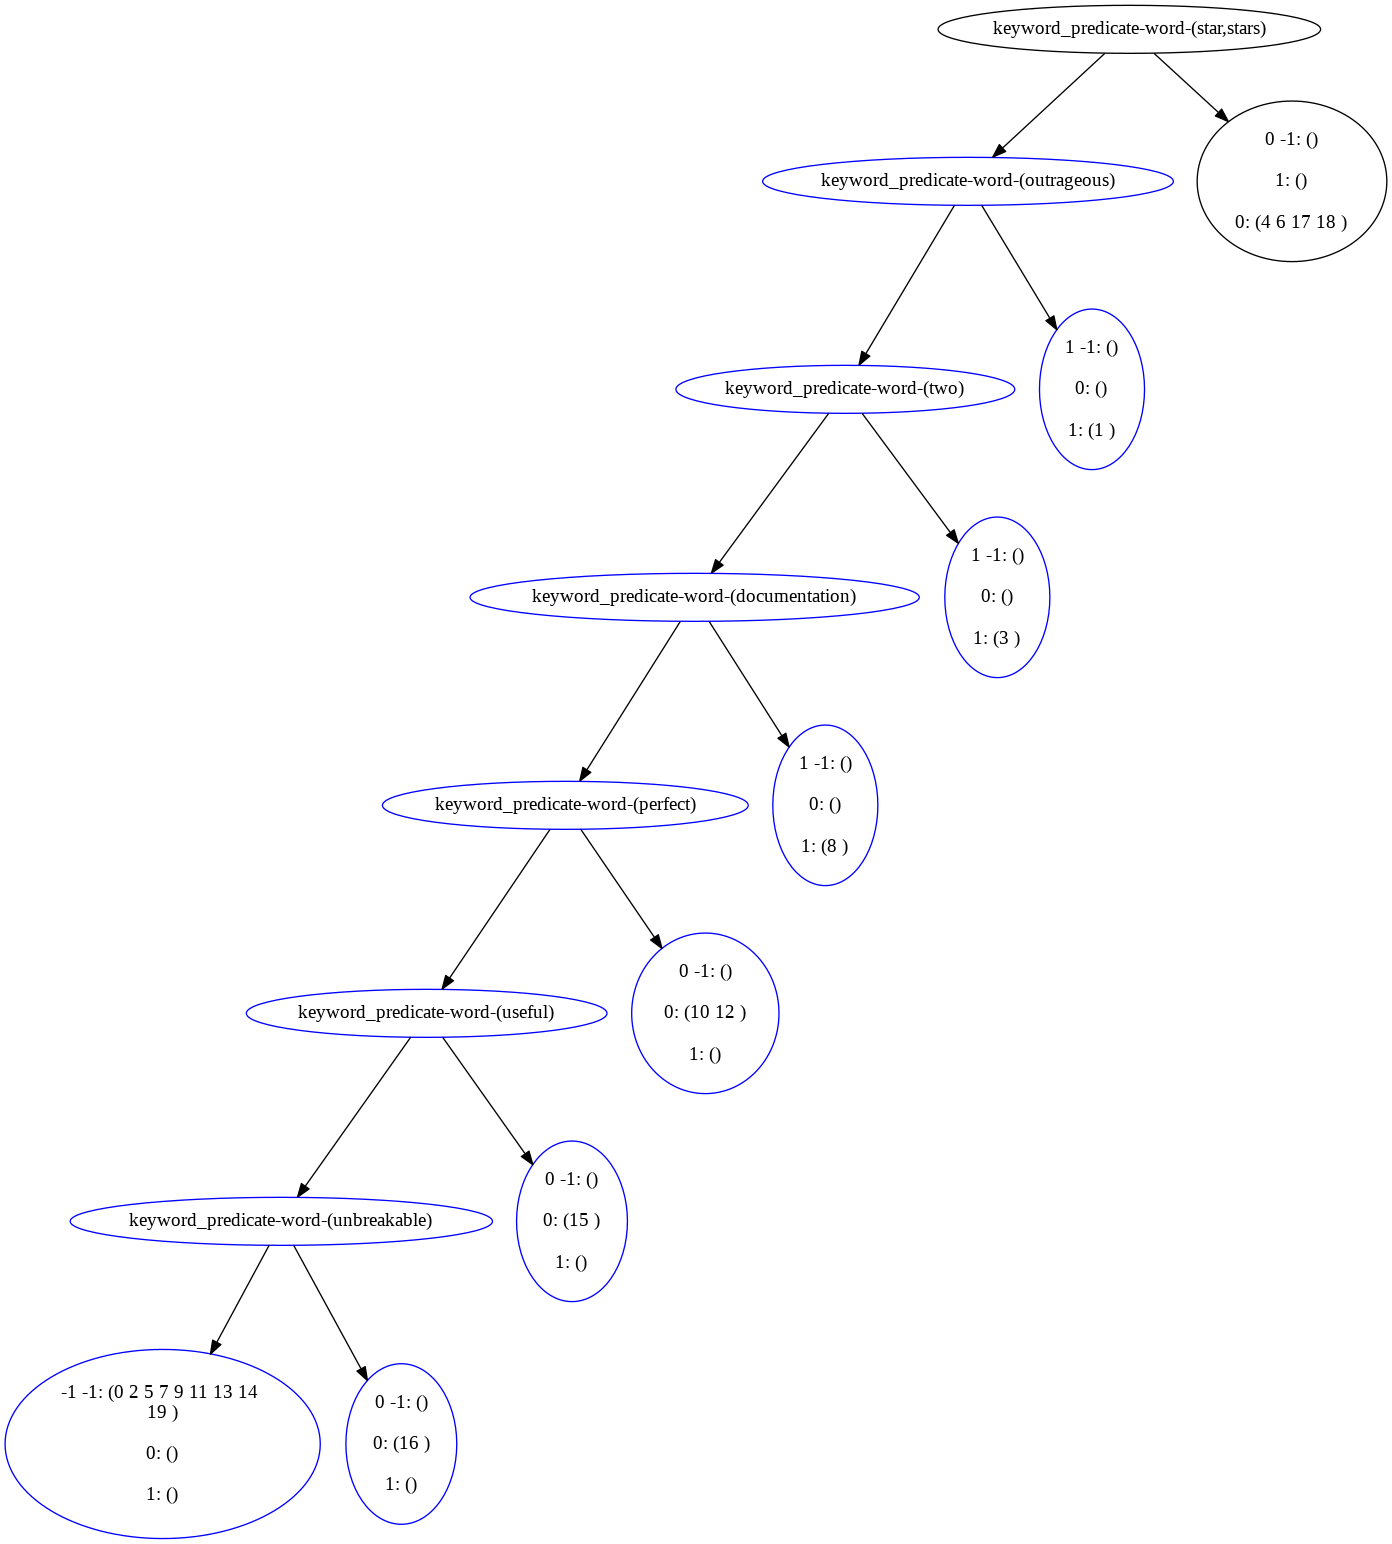

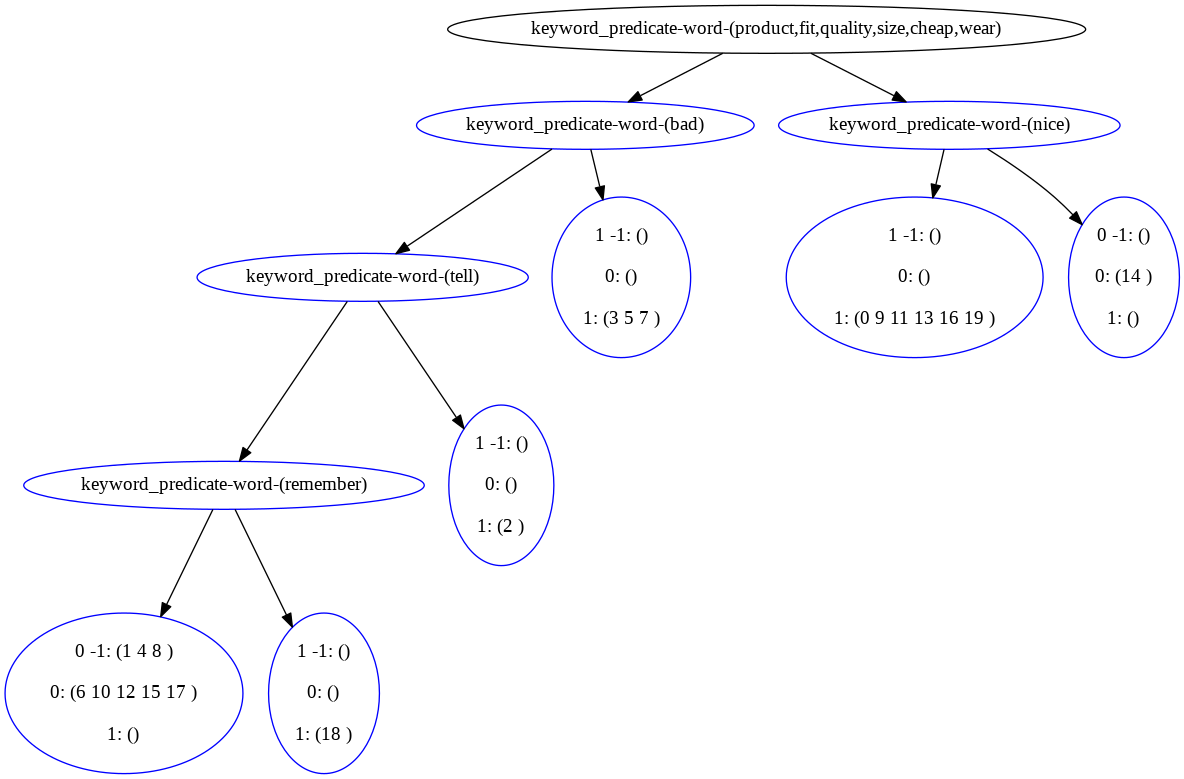

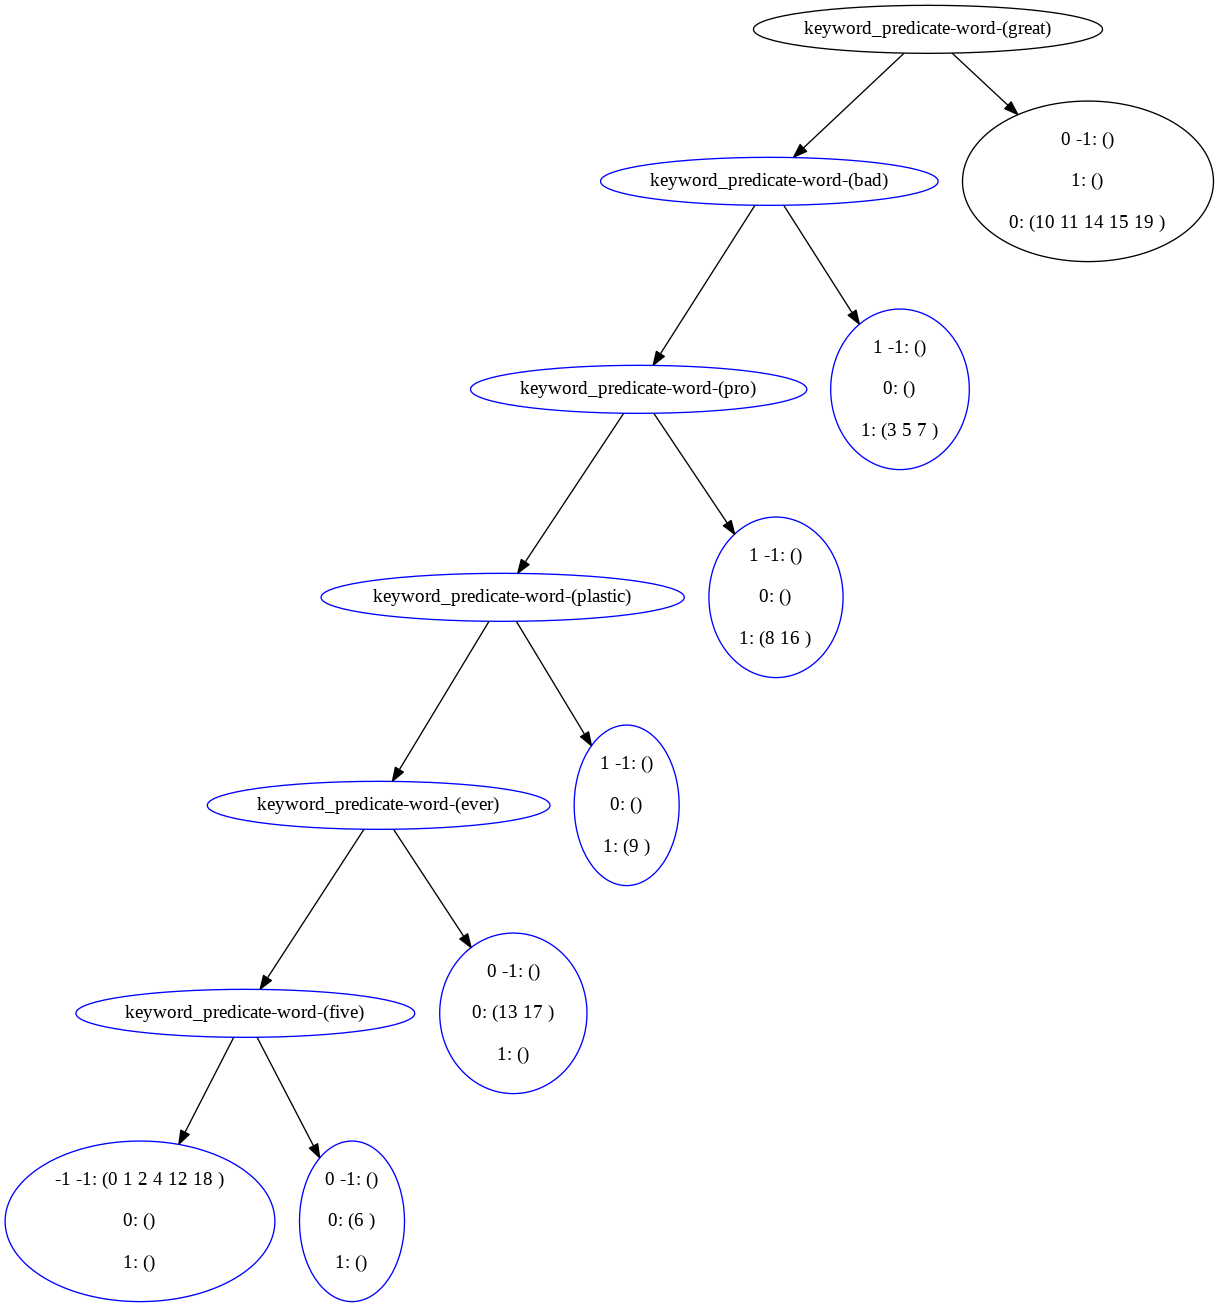

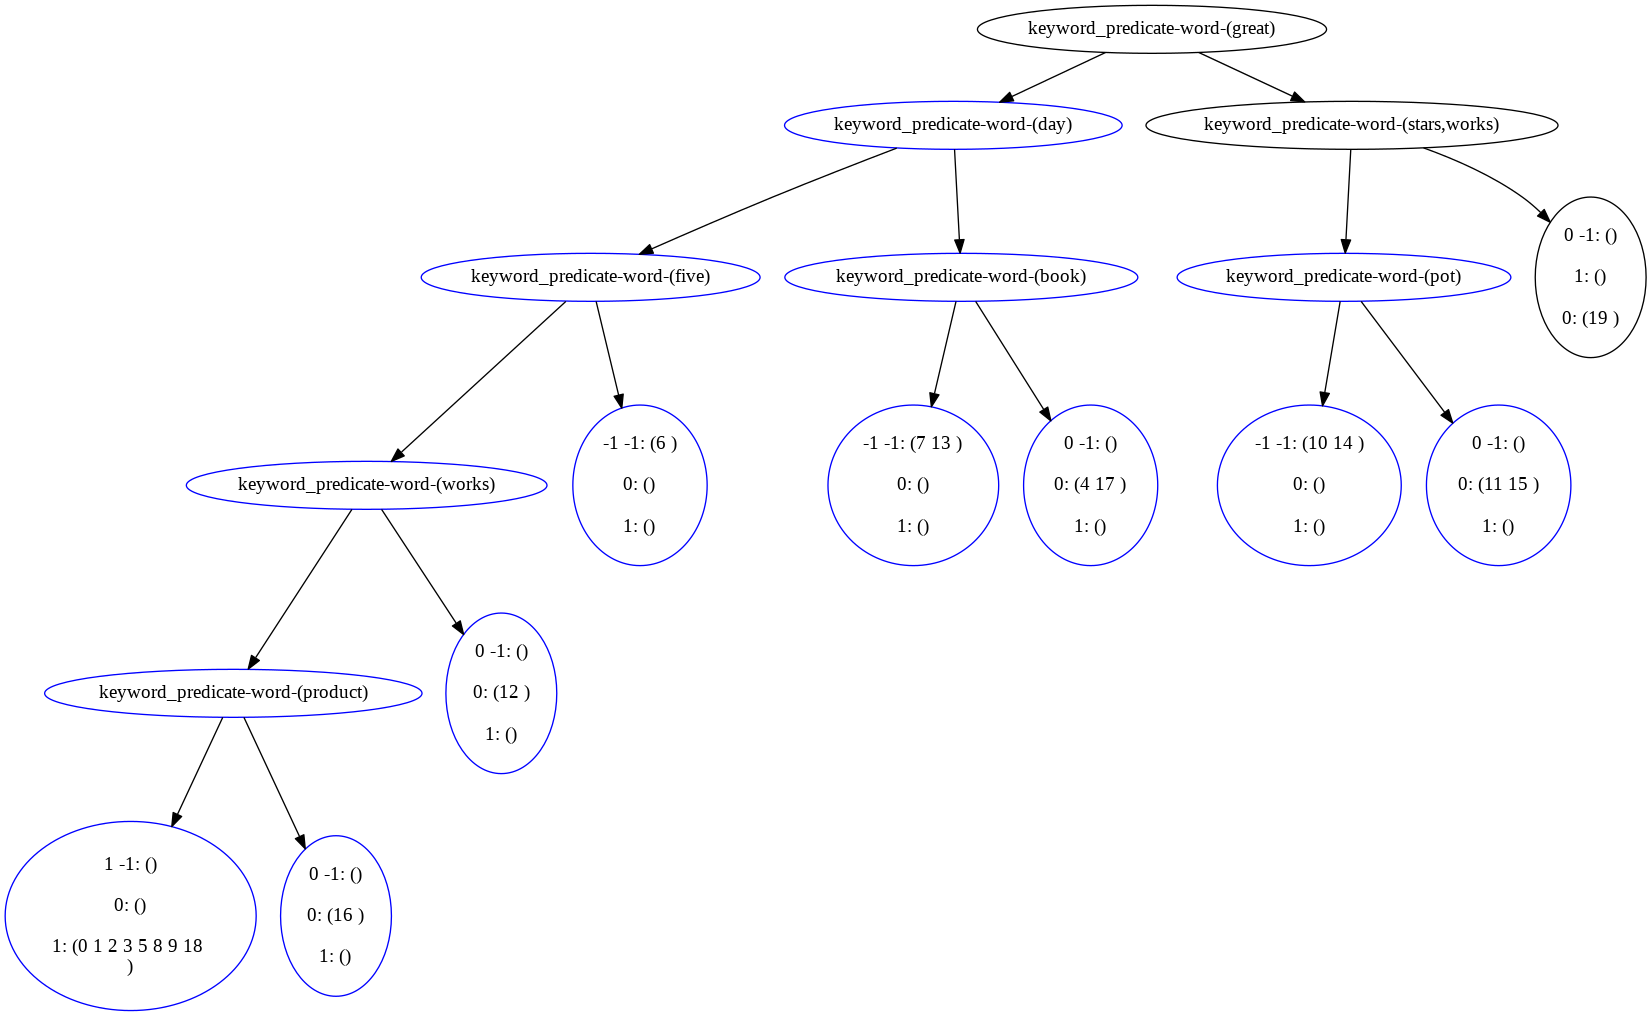

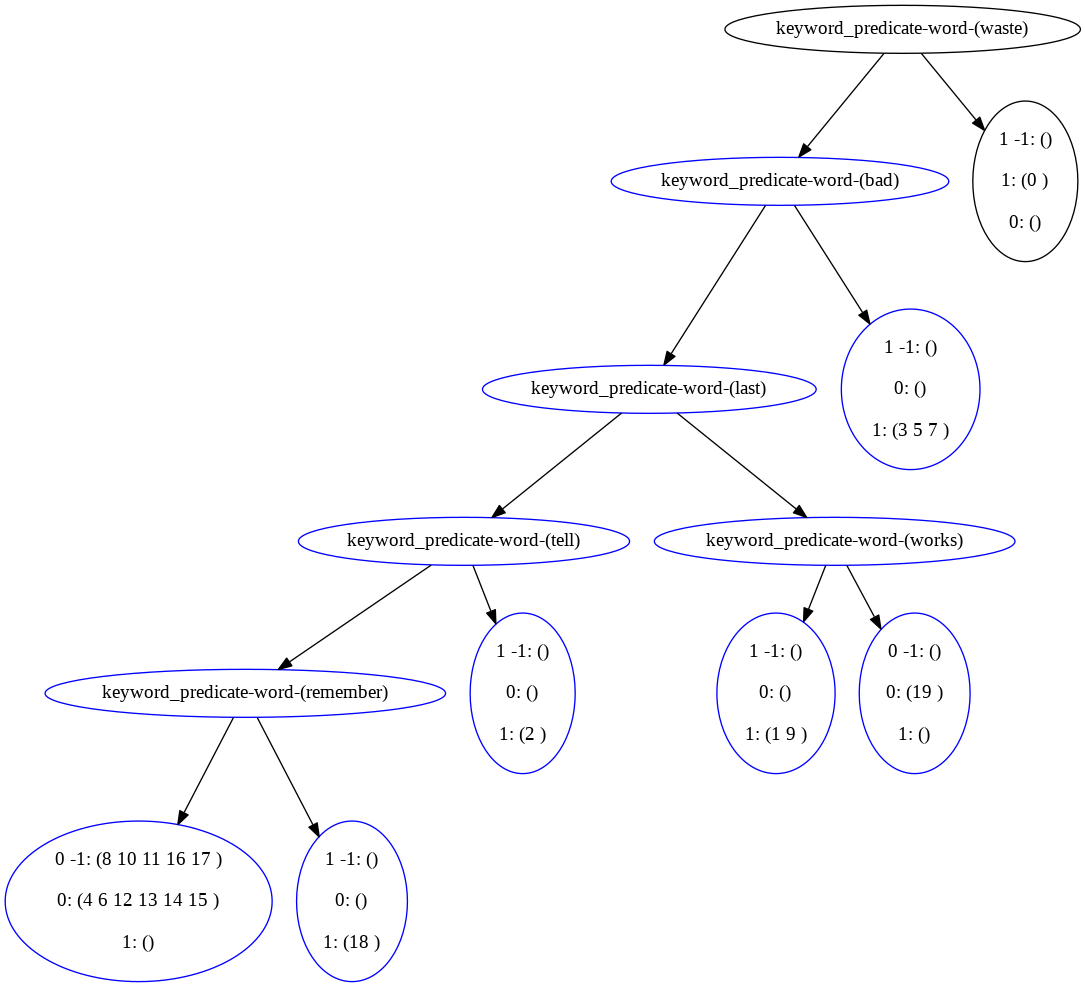

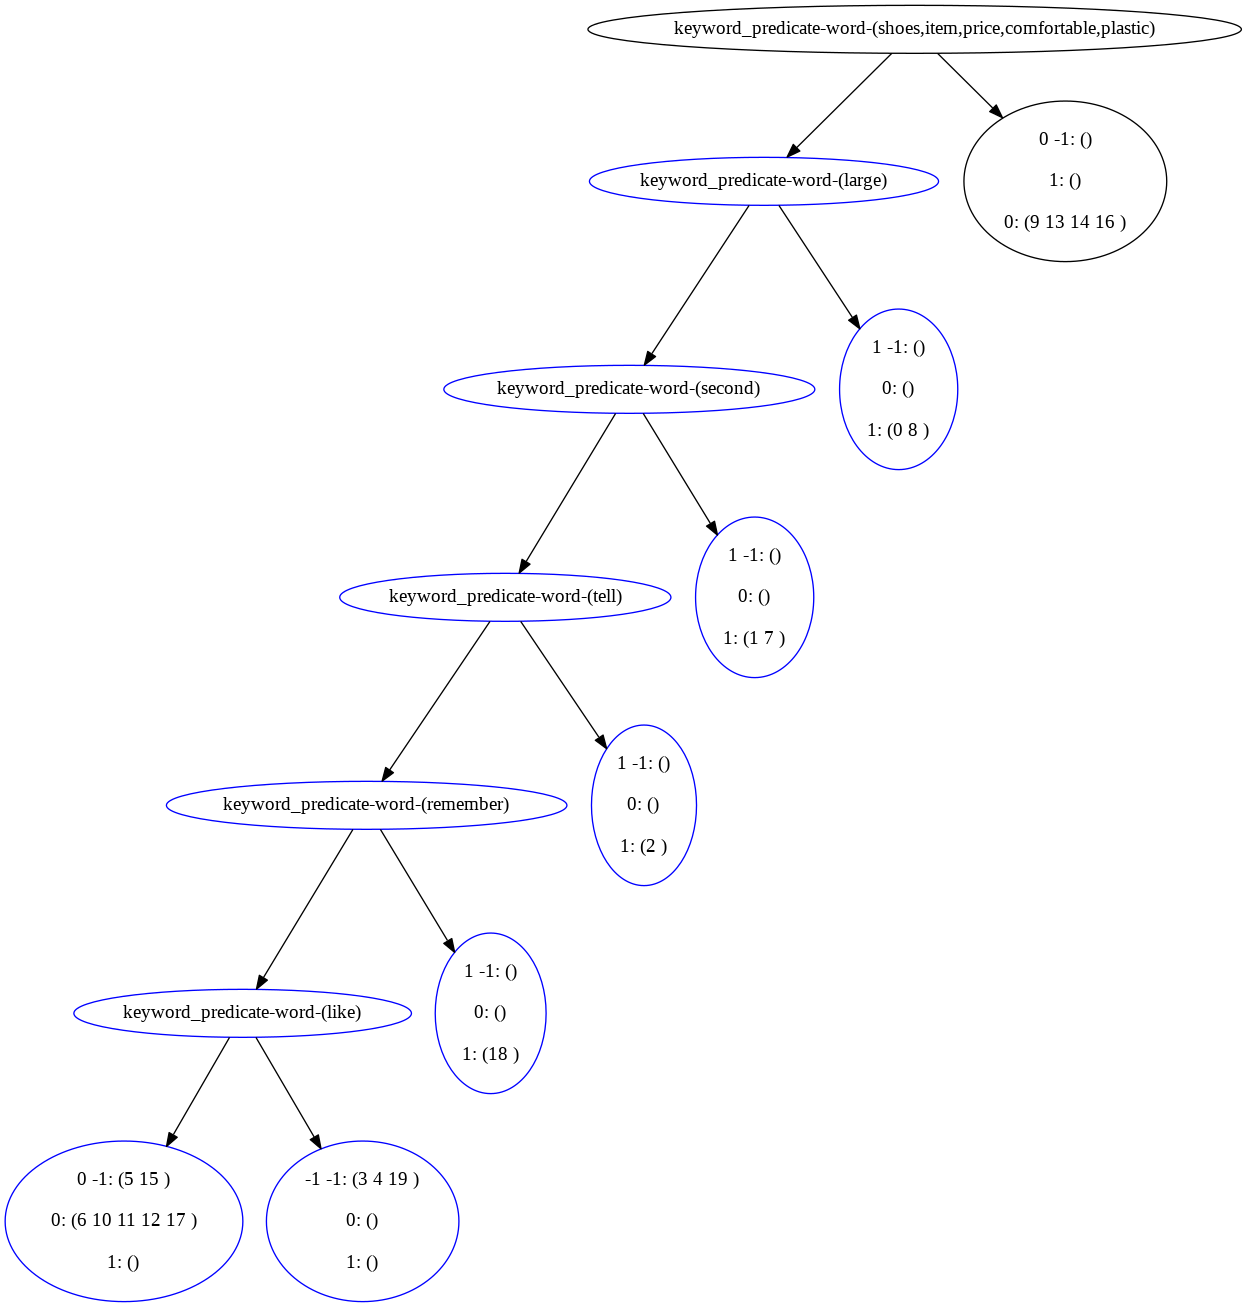

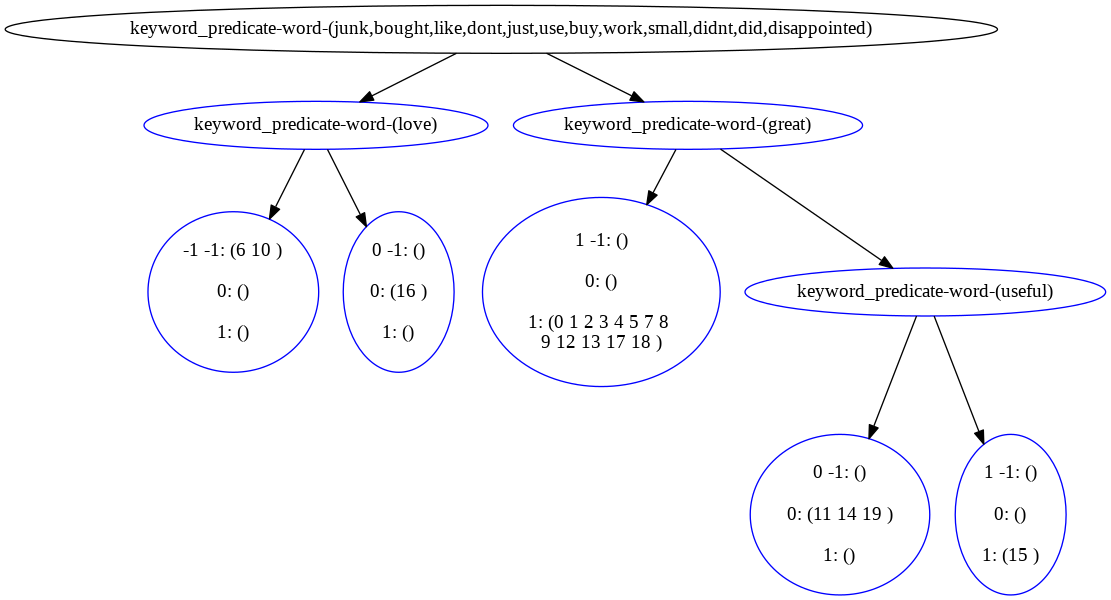

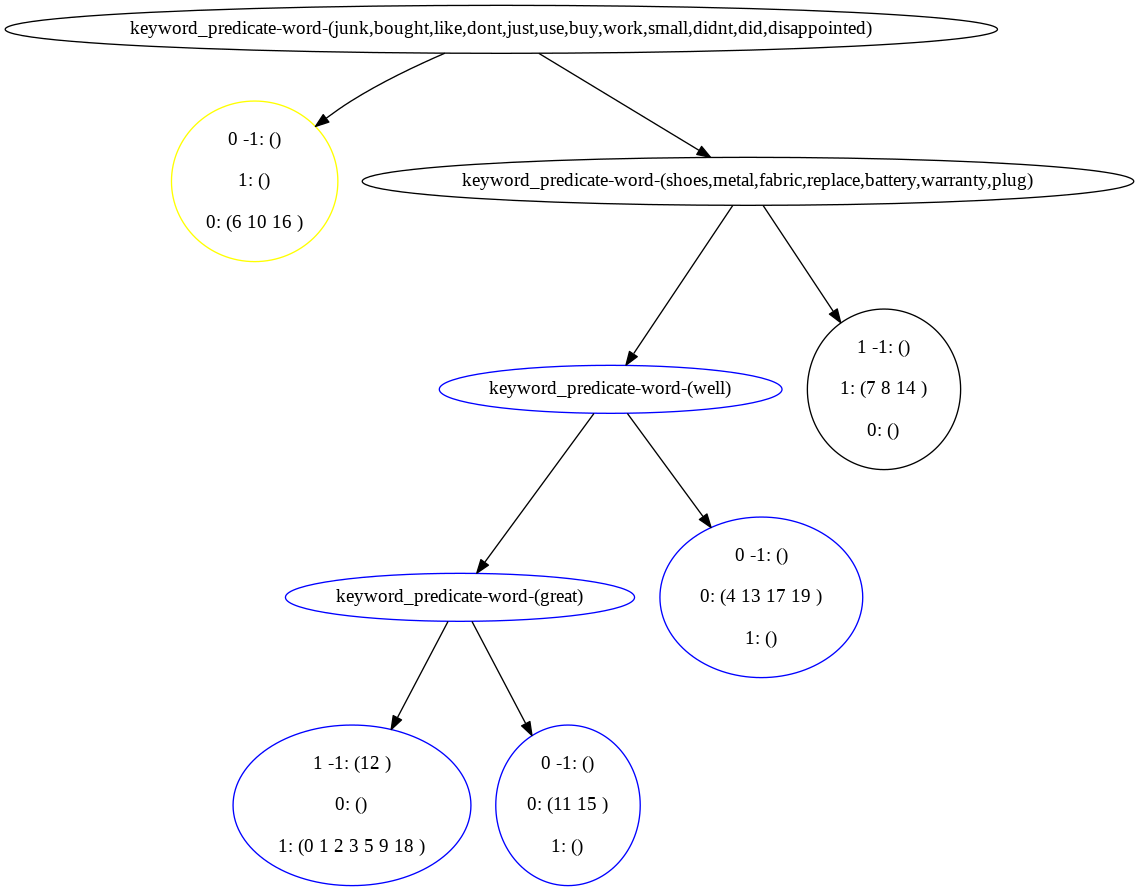

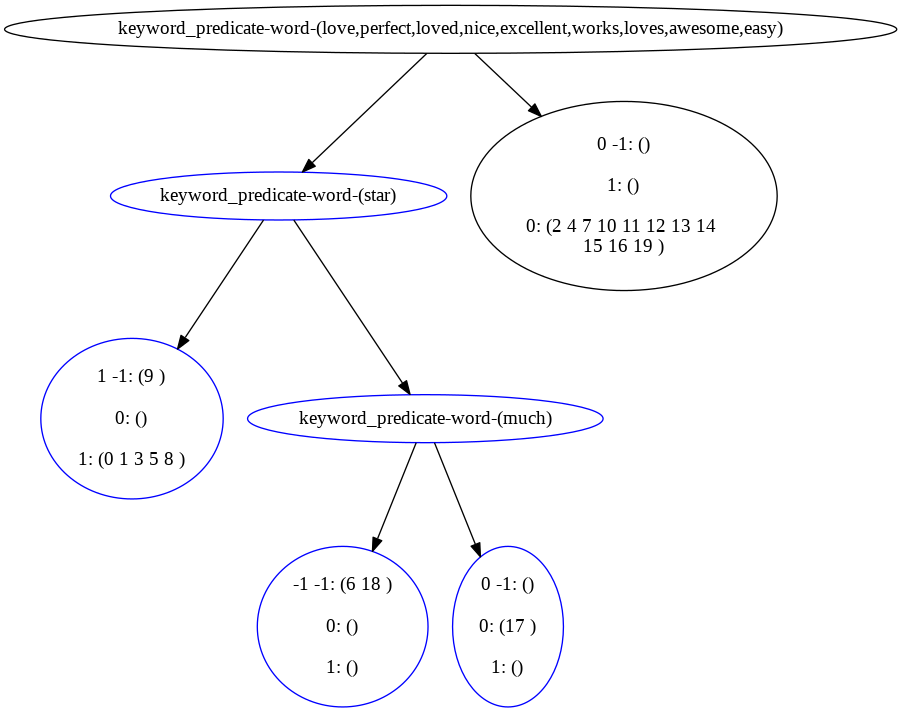

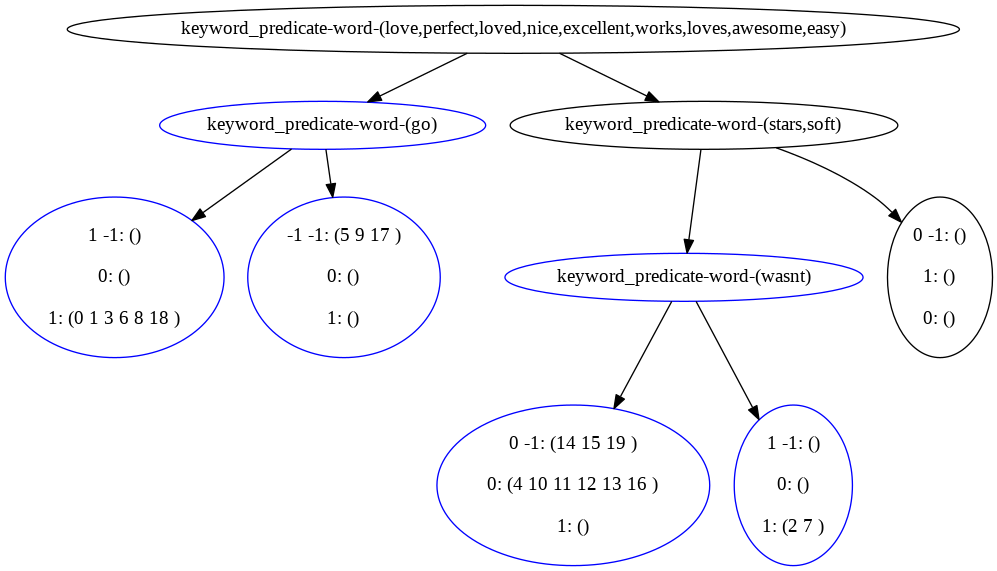

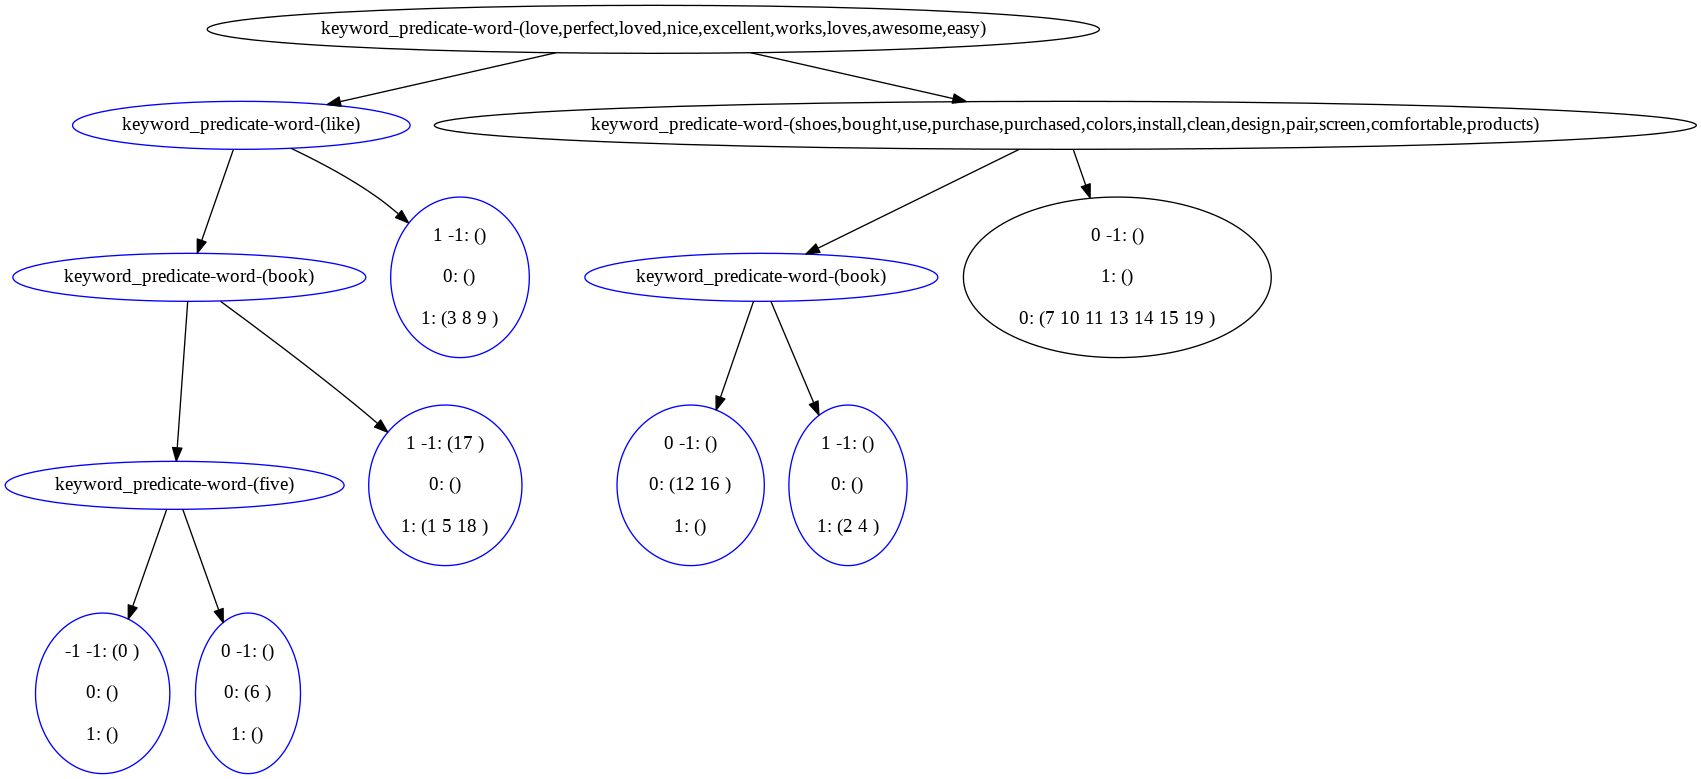

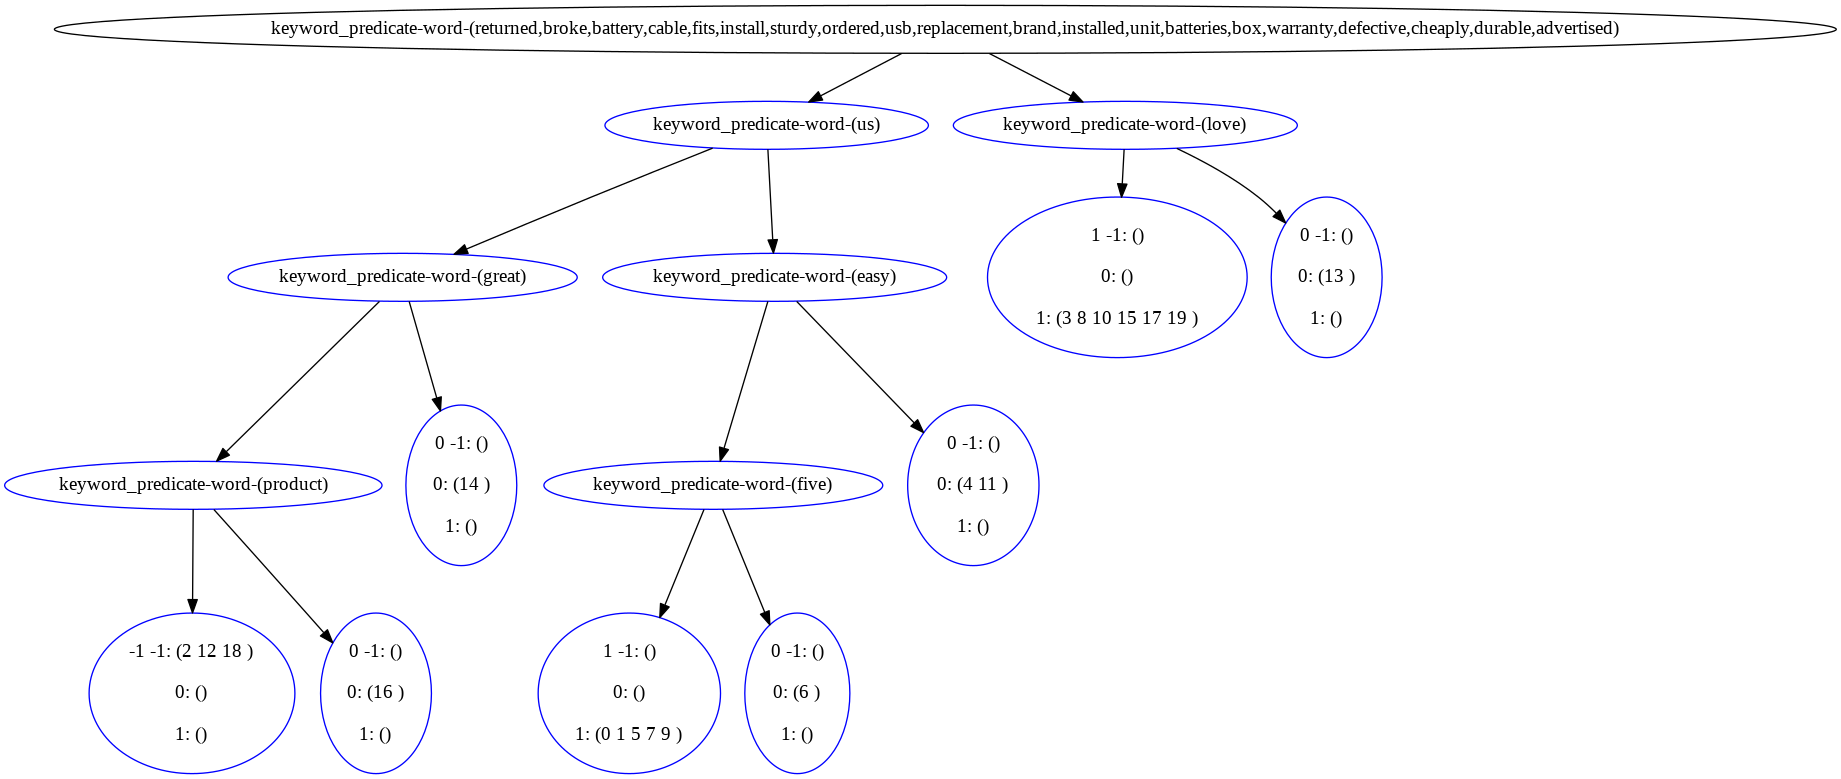

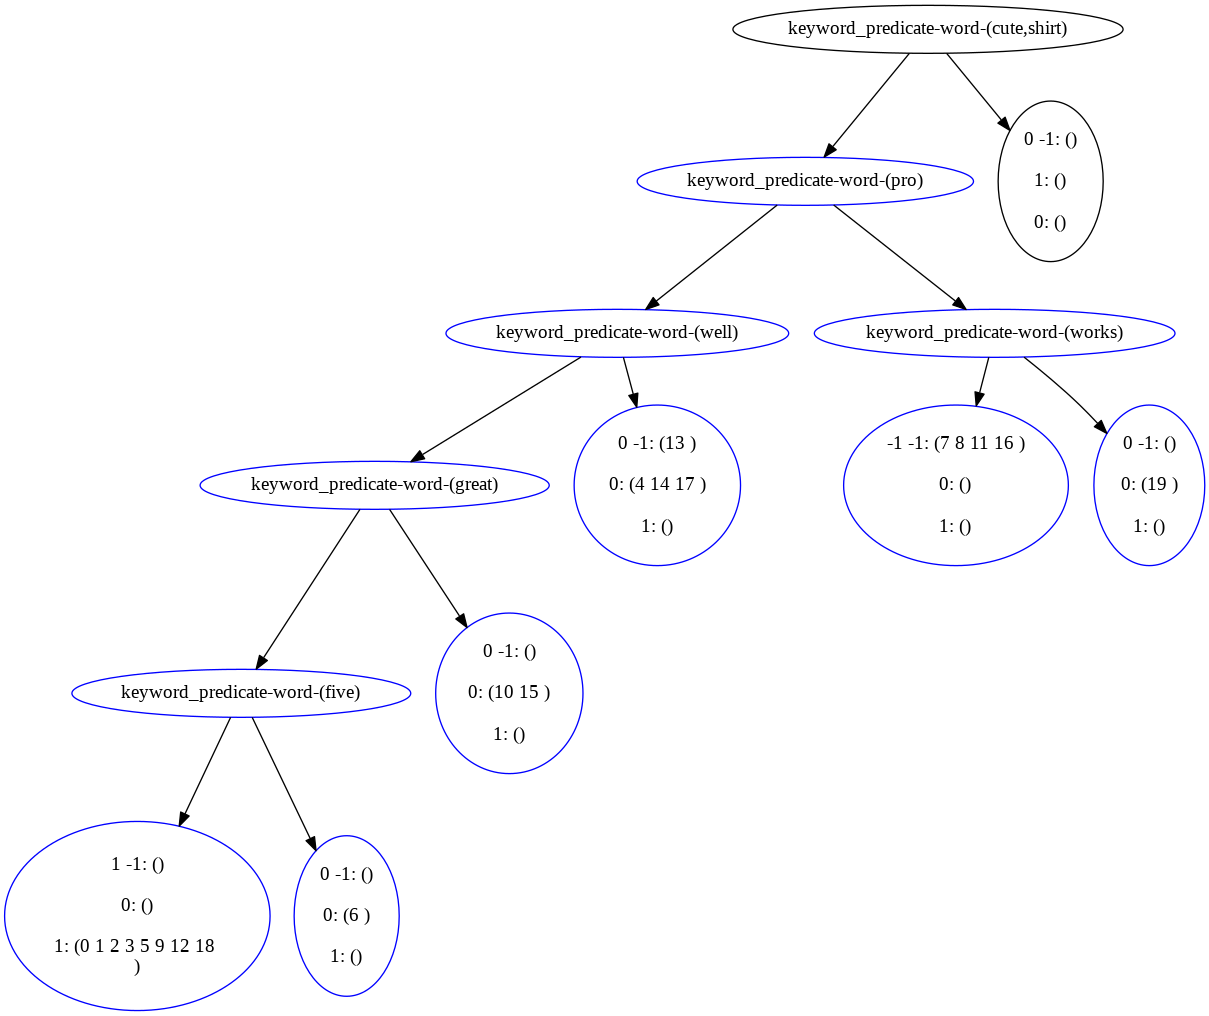

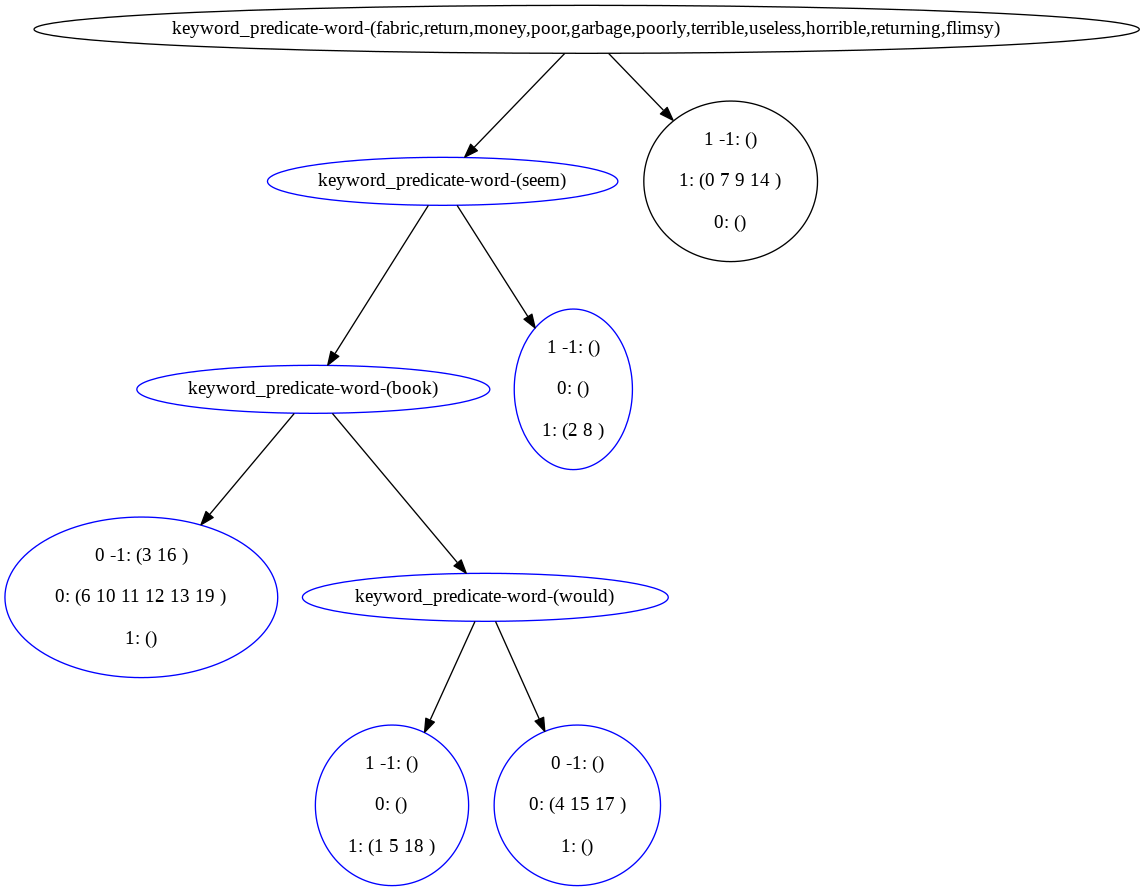

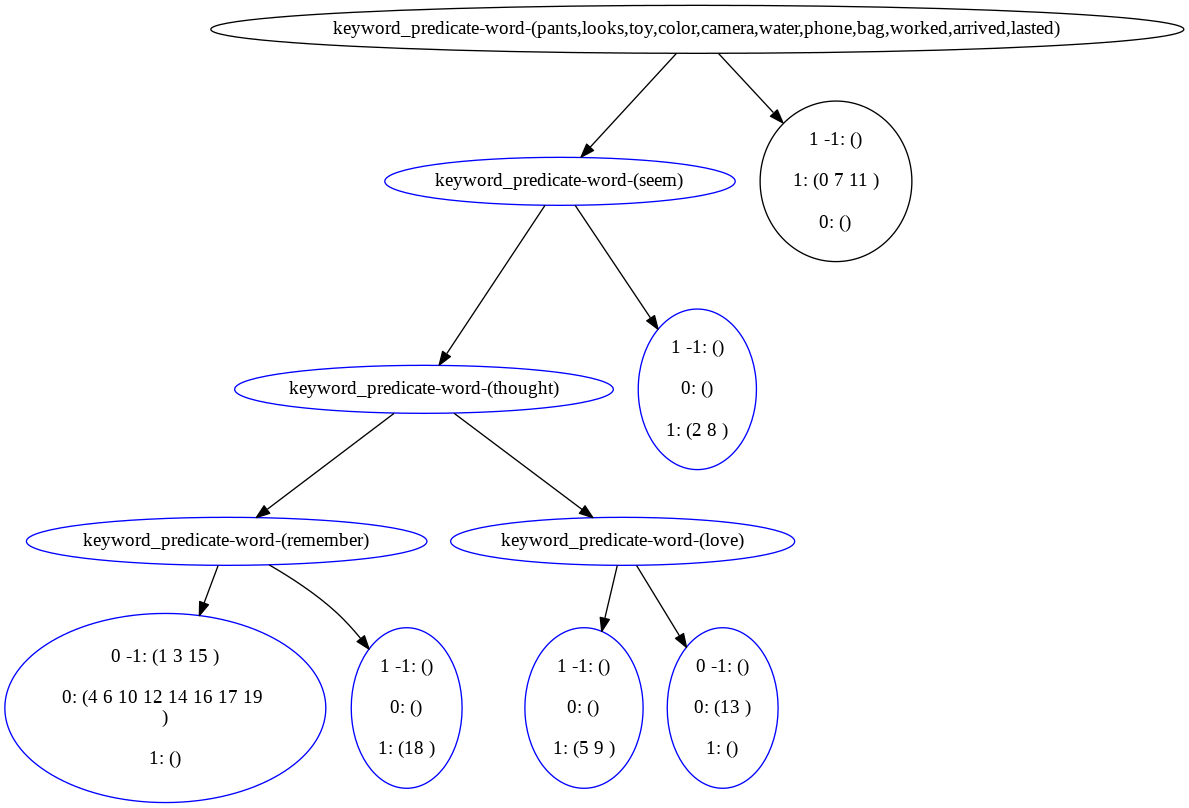

In [29]:
for r in rulecleaner_input['fix_details']:
    dot_string = rulecleaner_input['fix_details'][r]['rule'].gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [30]:
# run chatgpt refined rules

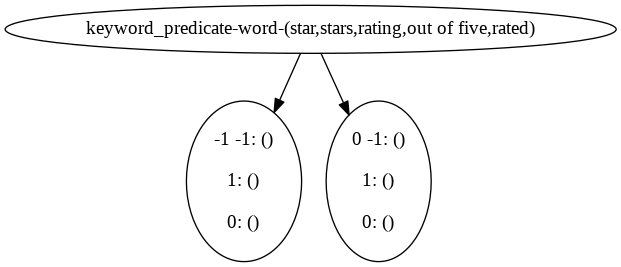

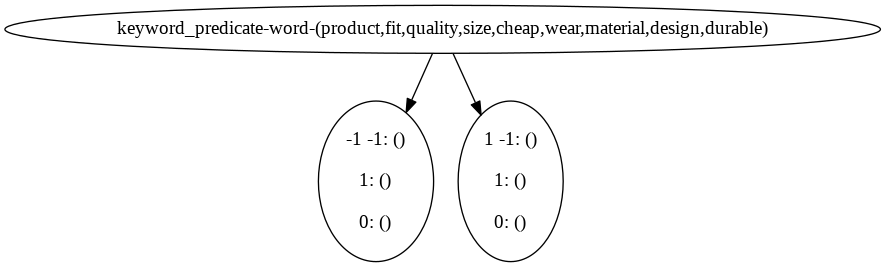

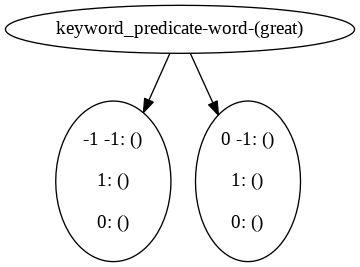

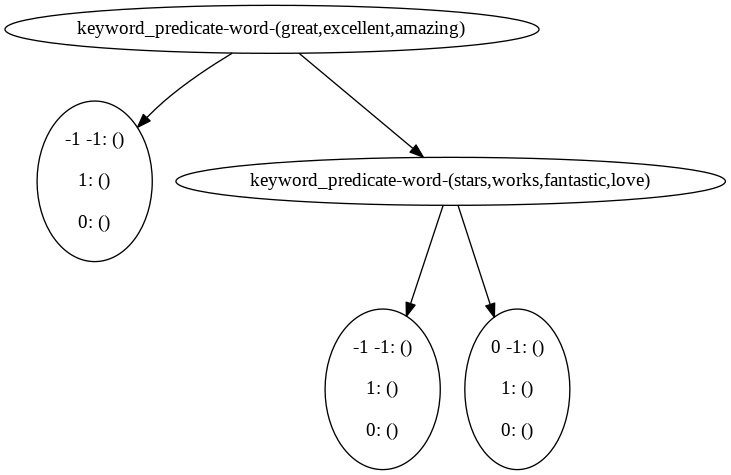

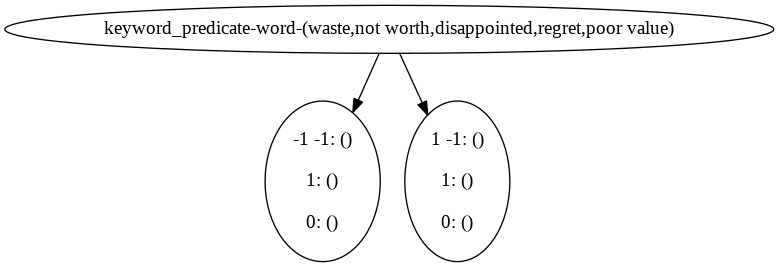

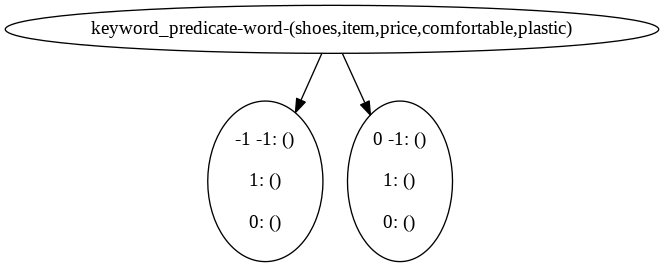

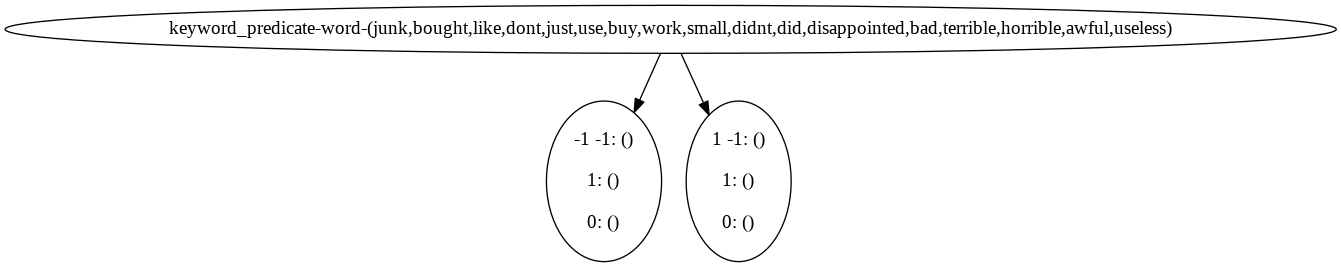

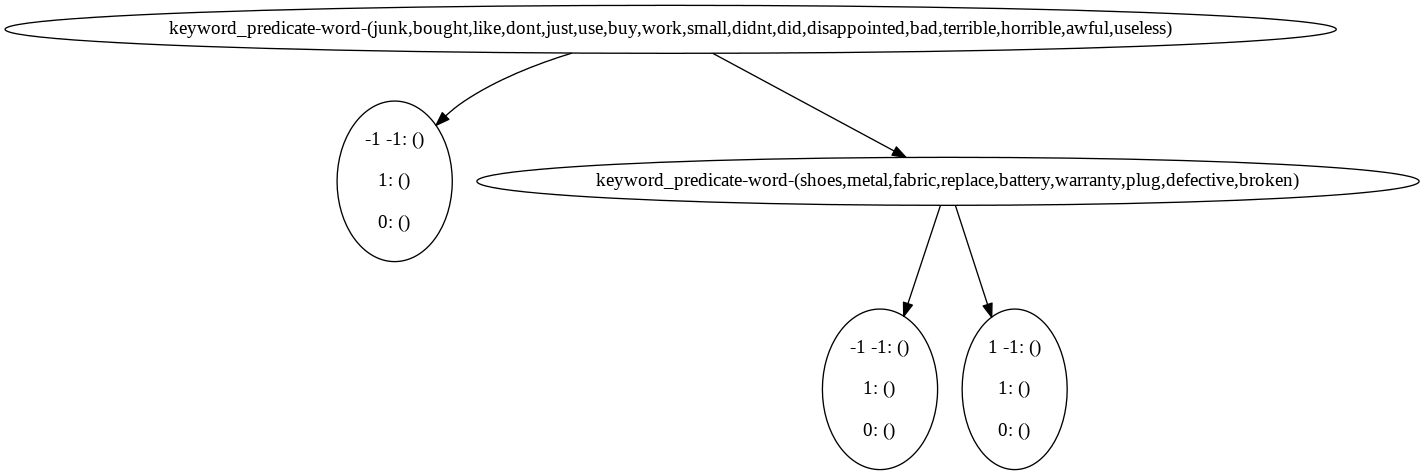

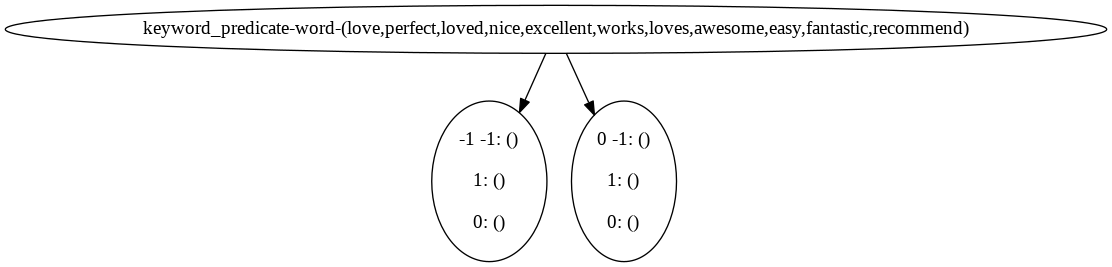

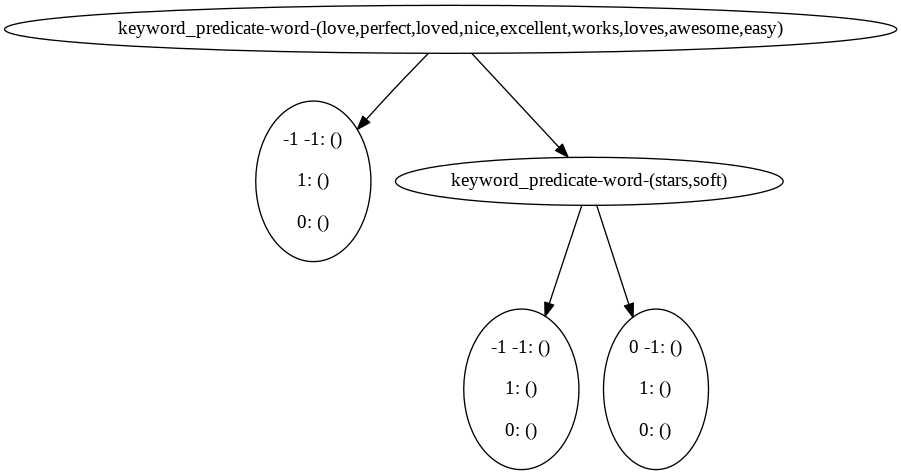

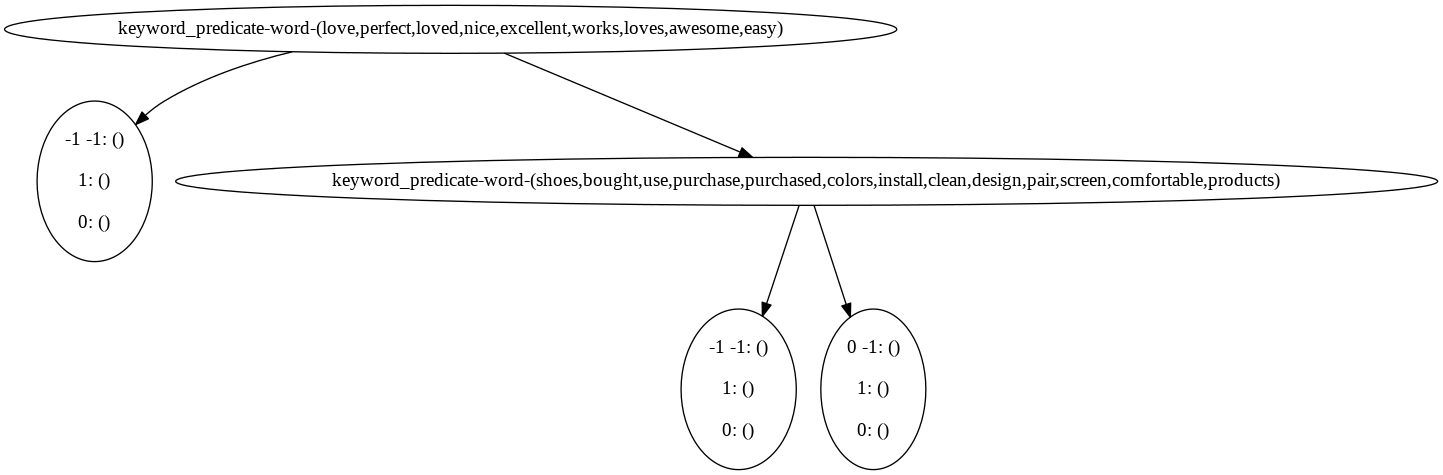

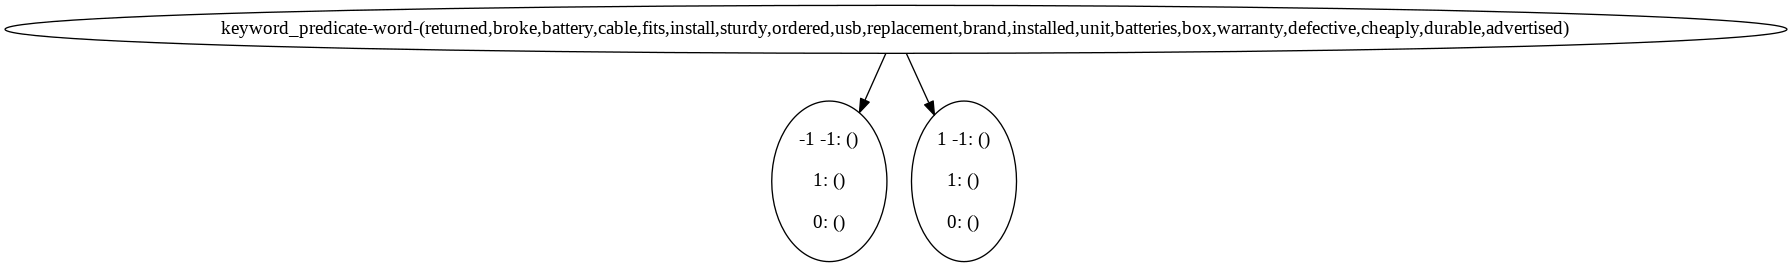

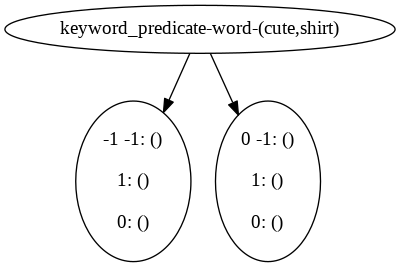

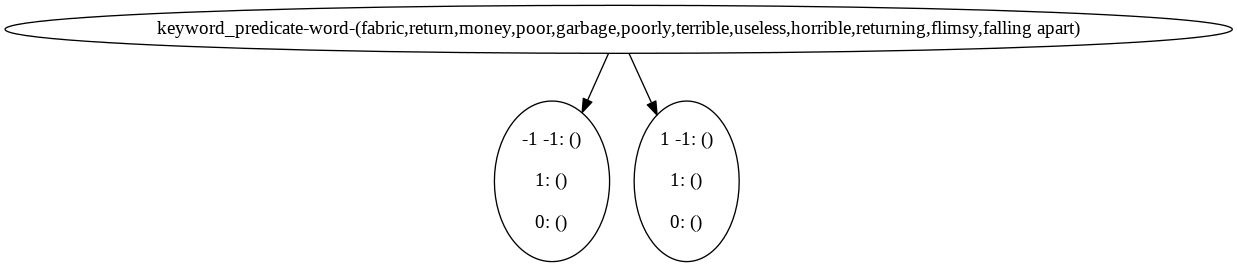

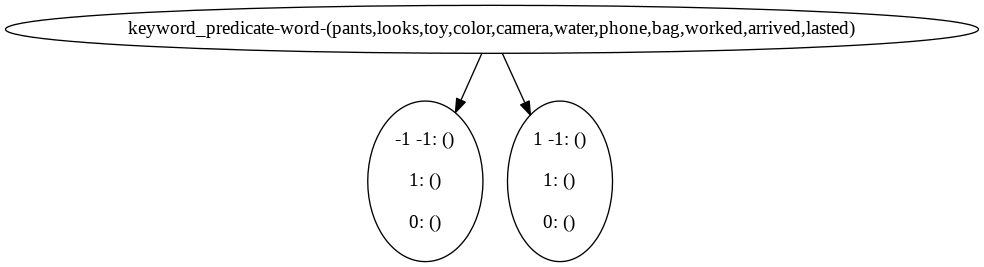

In [46]:
for r in chatgpt_refined_amazon_tree_rules:
    dot_string = r.gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [31]:
chatgpt_refined_amazon_tree_rules = gen_gpt_refined_amazon_funcs_user_input_20()

In [32]:
chatgpt_refined_amazon_tree_funcs = [f.gen_label_rule() for f in chatgpt_refined_amazon_tree_rules]

In [37]:
conn = psycopg2.connect(dbname='label', user='postgres')

In [39]:
 new_df_sentences_filtered, new_correct_preds_by_snorkel, new_wrong_preds_by_snorkel, new_filtered_vectors, new_correct_predictions, \
    new_incorrect_predictions, new_global_accuracy, new_global_accuracy_on_valid = run_snorkel_with_funcs(dataset_name='amazon', funcs=chatgpt_refined_amazon_tree_funcs, conn=conn)


/tmp/ipykernel_12376/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:29:47,127 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:29:47,171 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 730.99epoch/s]
INFO 2024-10-17 21:29:47,860 [label_model.py:fit:977] Finished Training



        out of 199591 sentences, 190434 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 51326 wrong predictions, 

        accuracy = 0.7304788010544335 
    


In [40]:
new_global_accuracy

0.6969652940262837

In [45]:
rule_cleaner_refined_trees = [rulecleaner_input['fix_details'][x]['rule'] for x in rulecleaner_input['fix_details']]

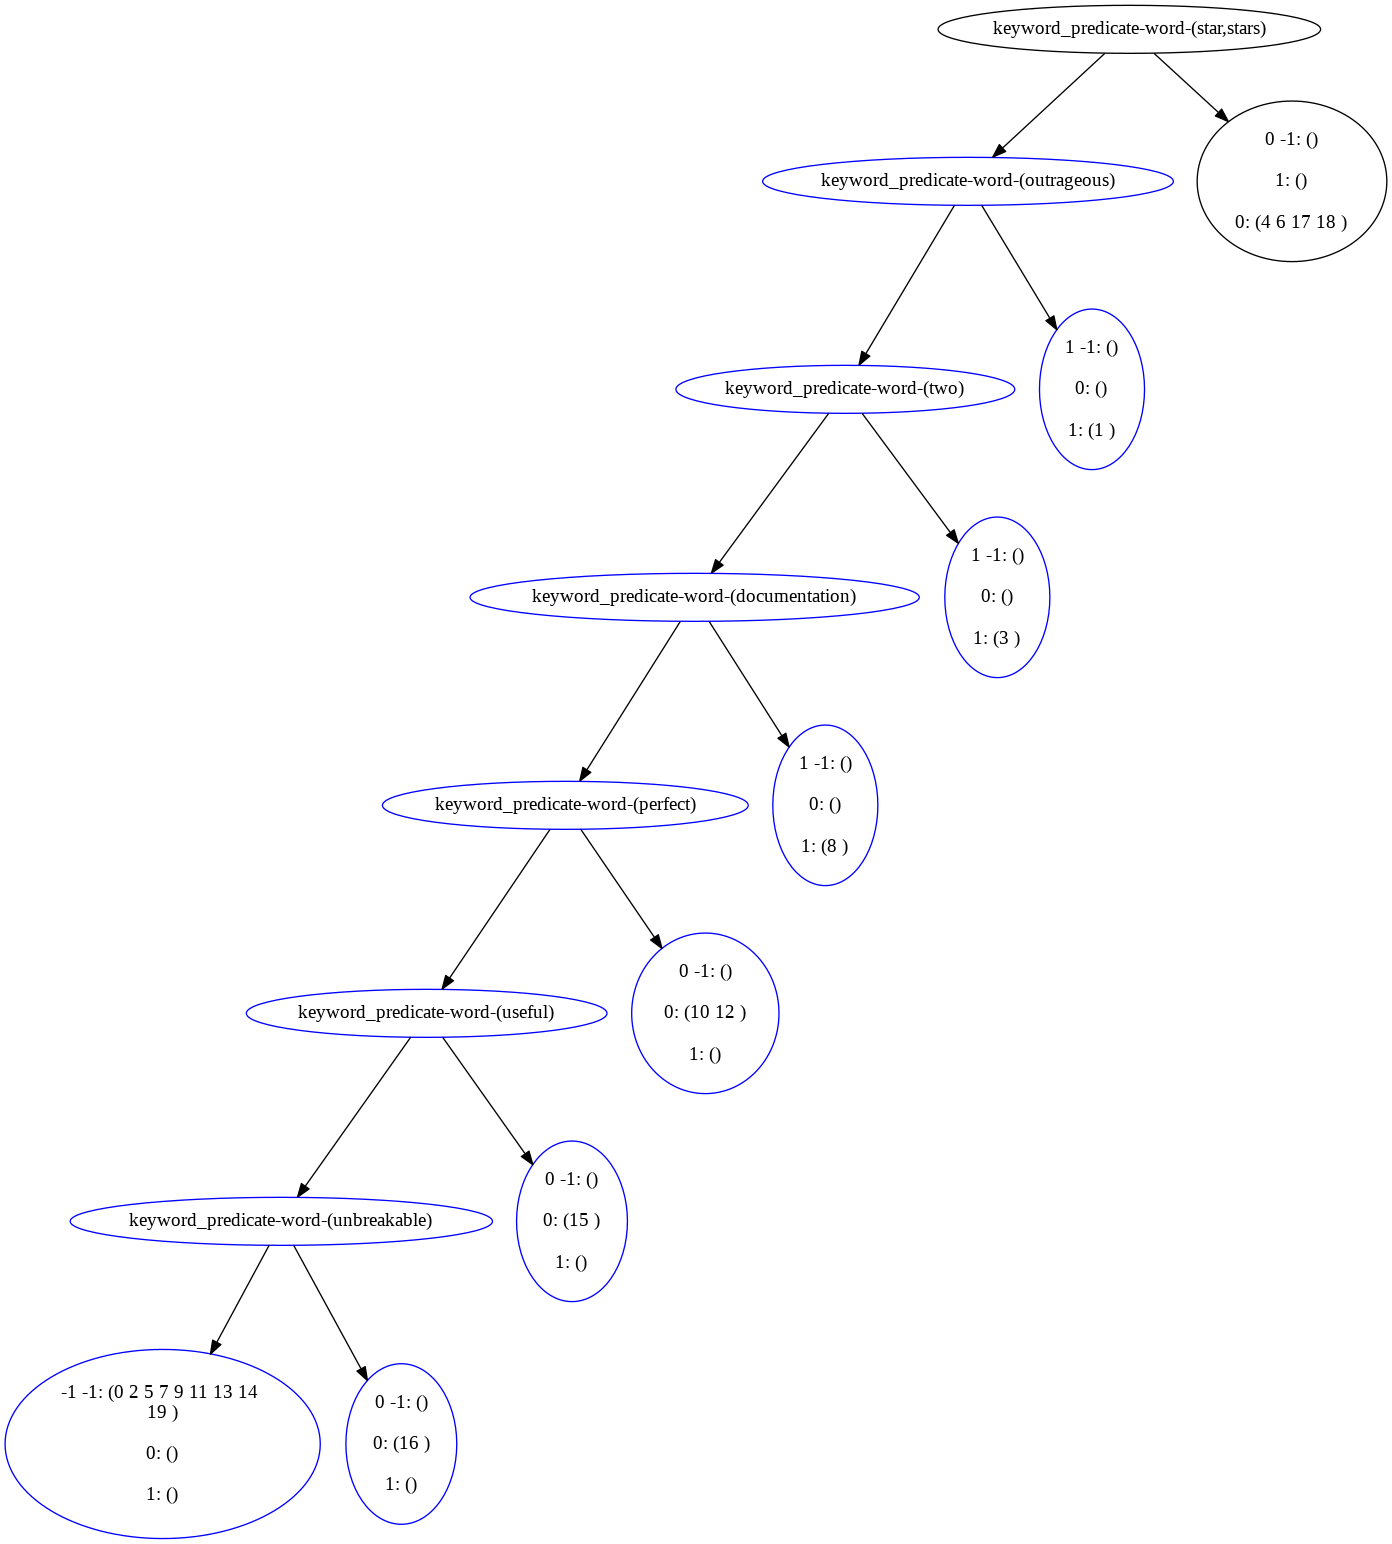

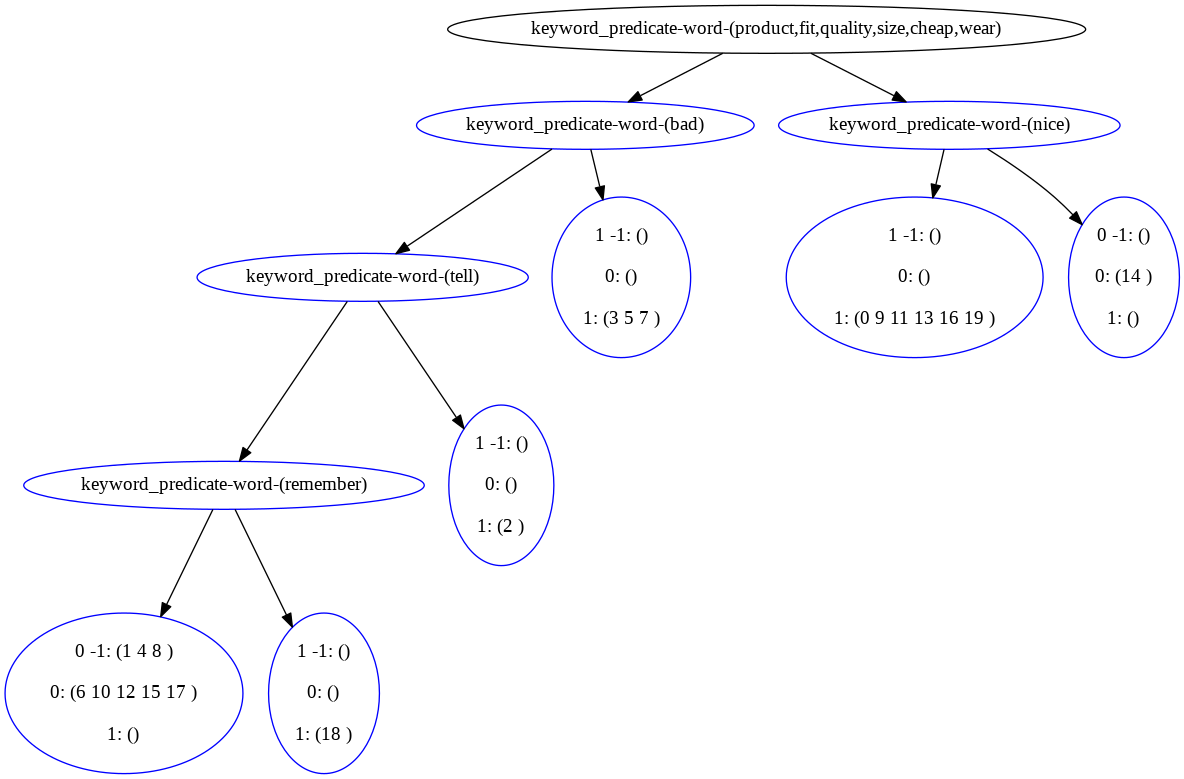

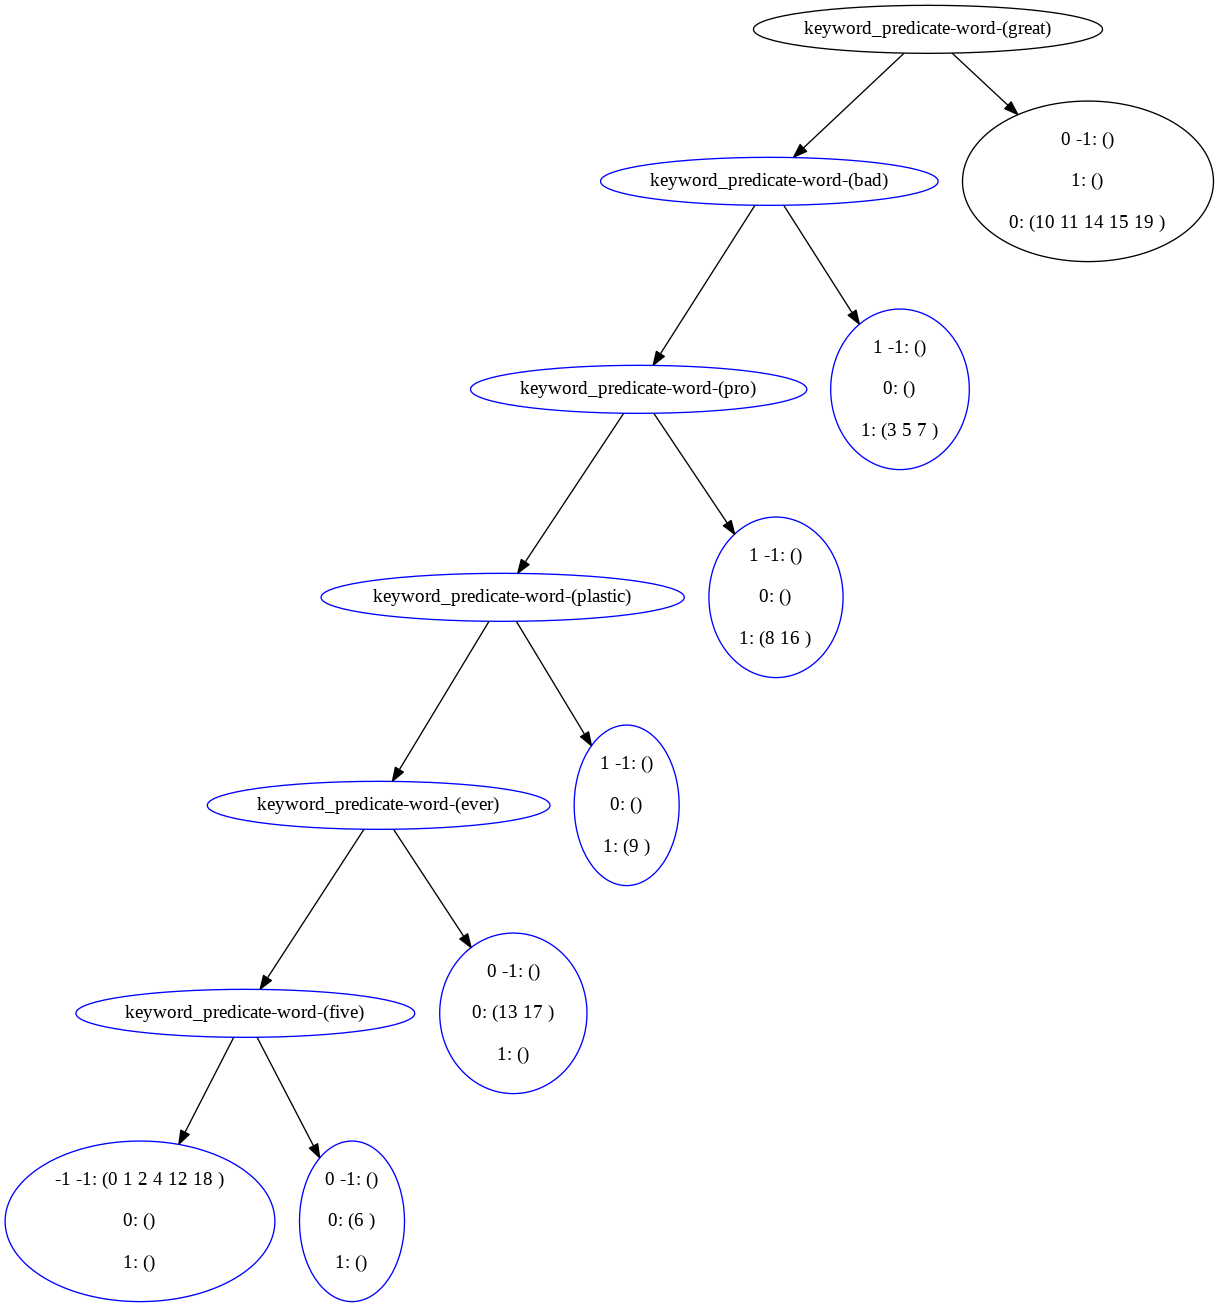

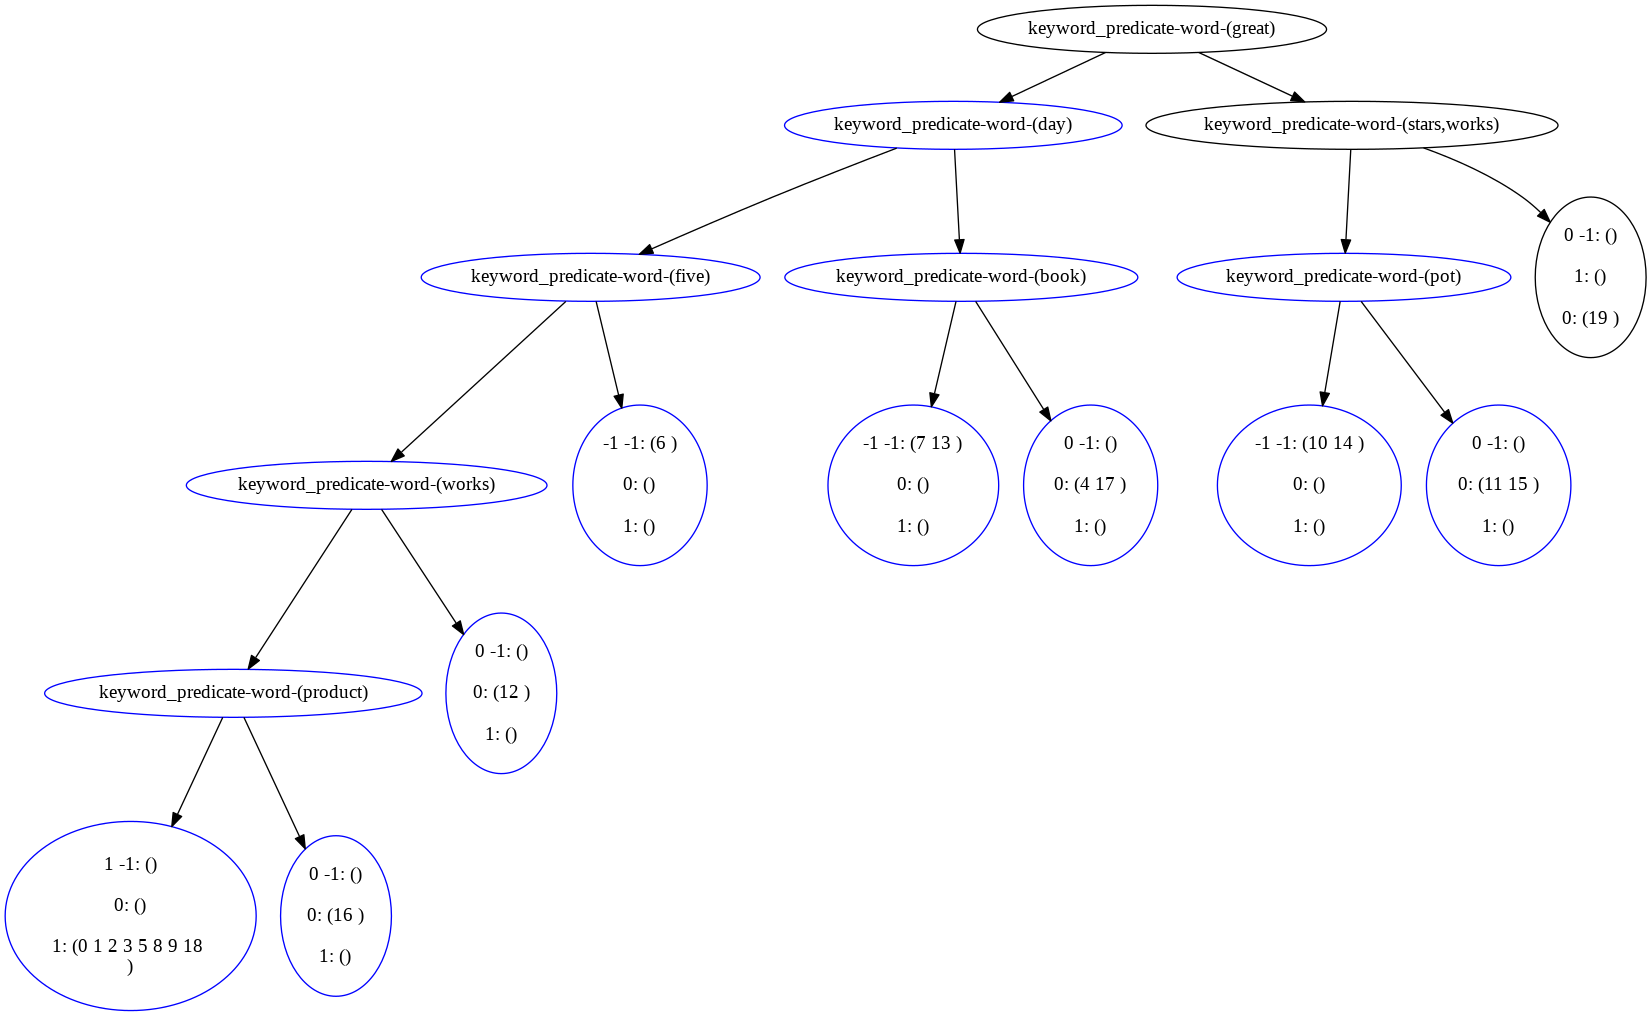

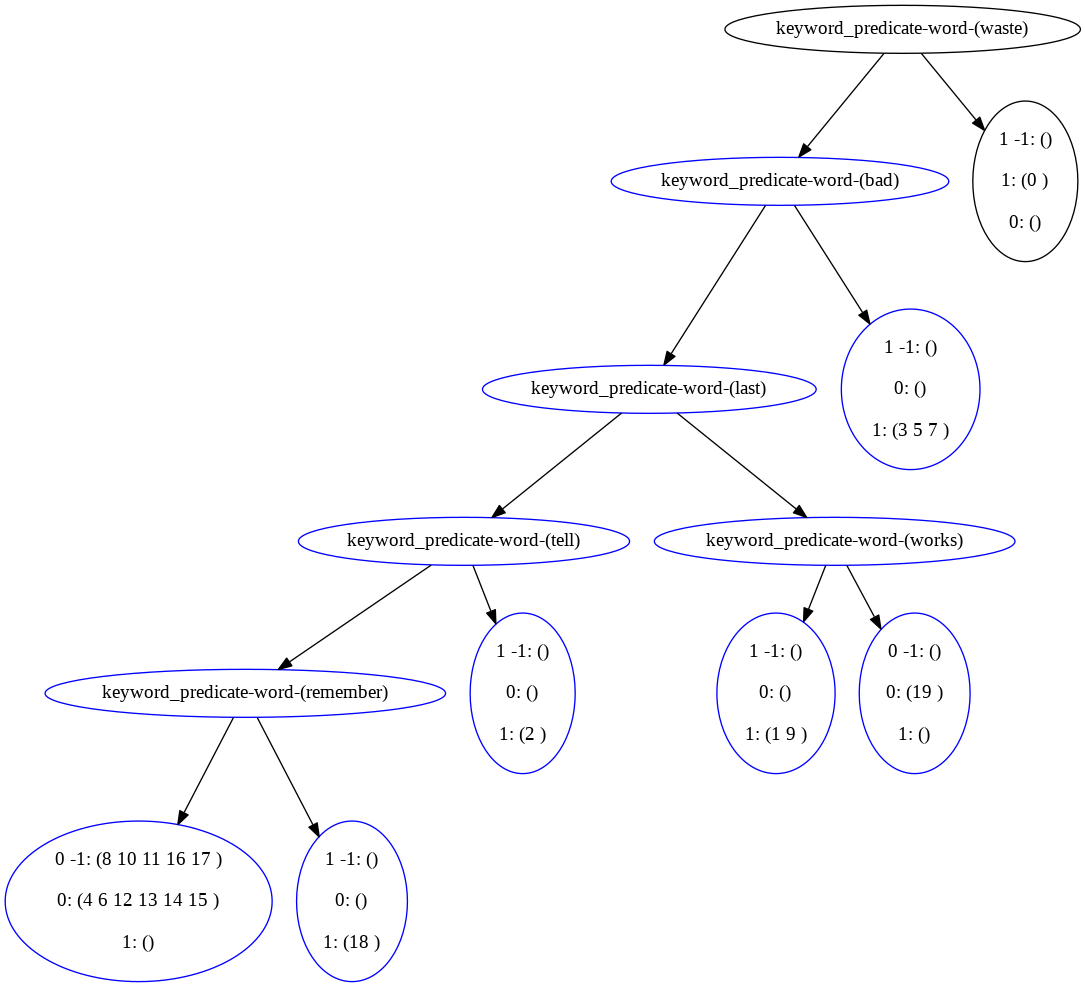

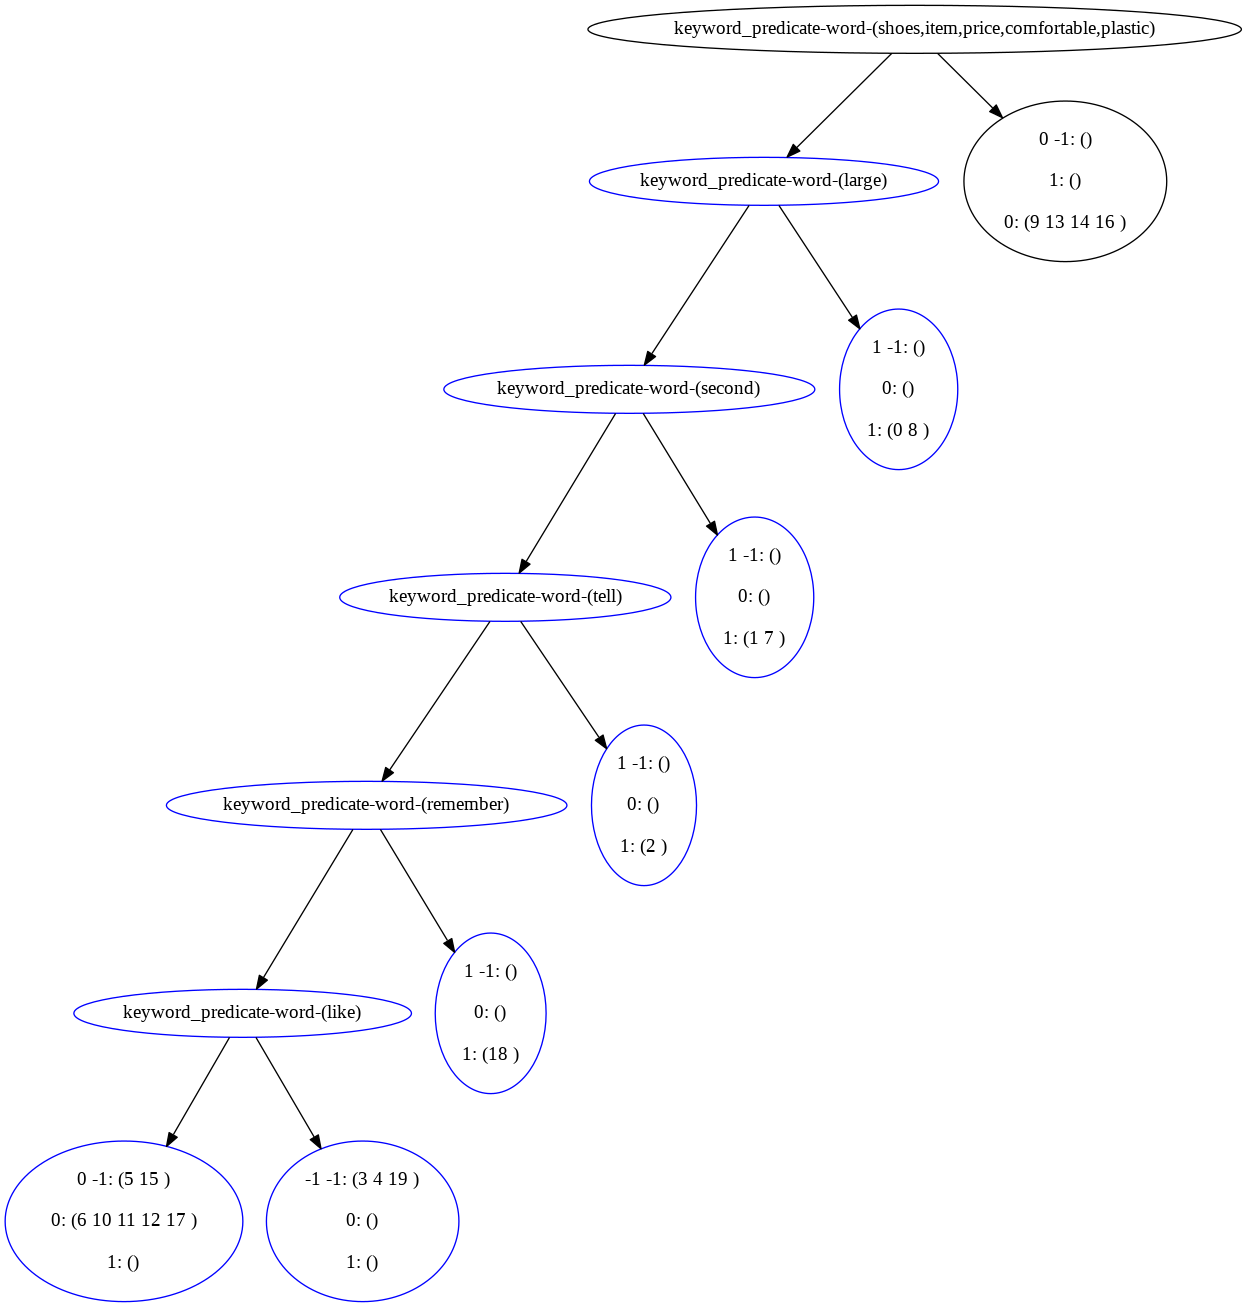

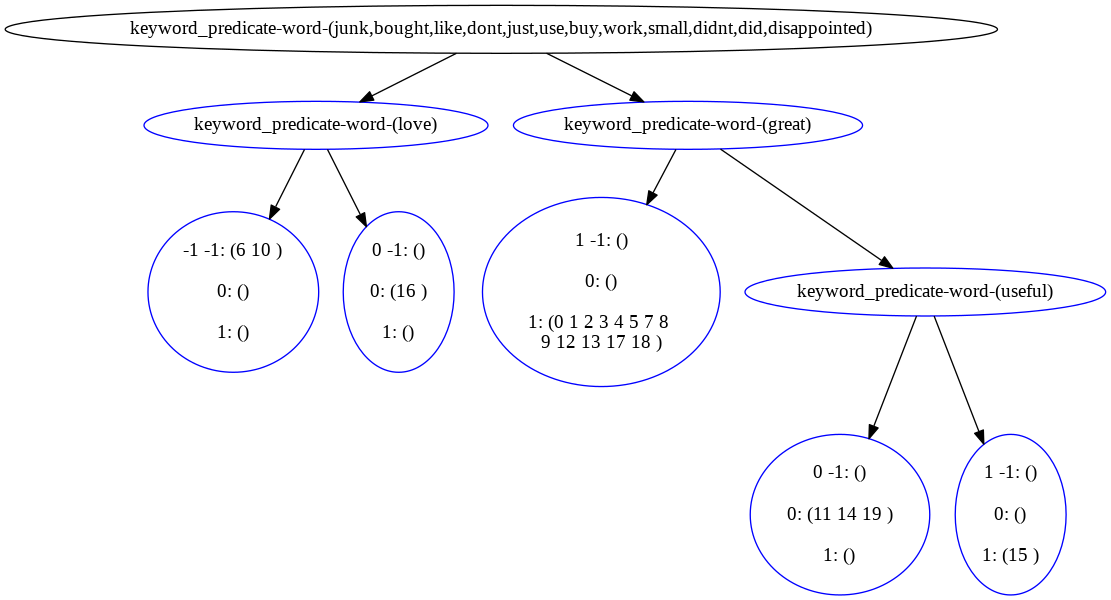

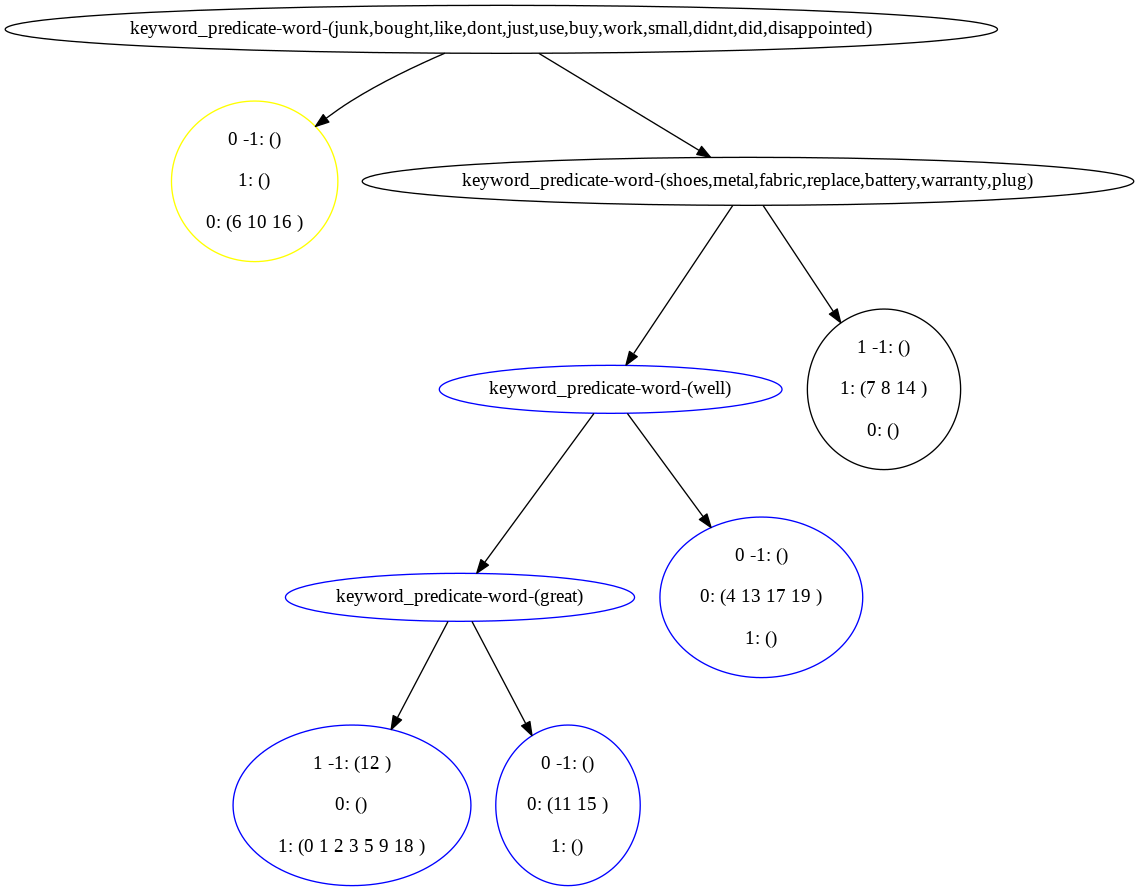

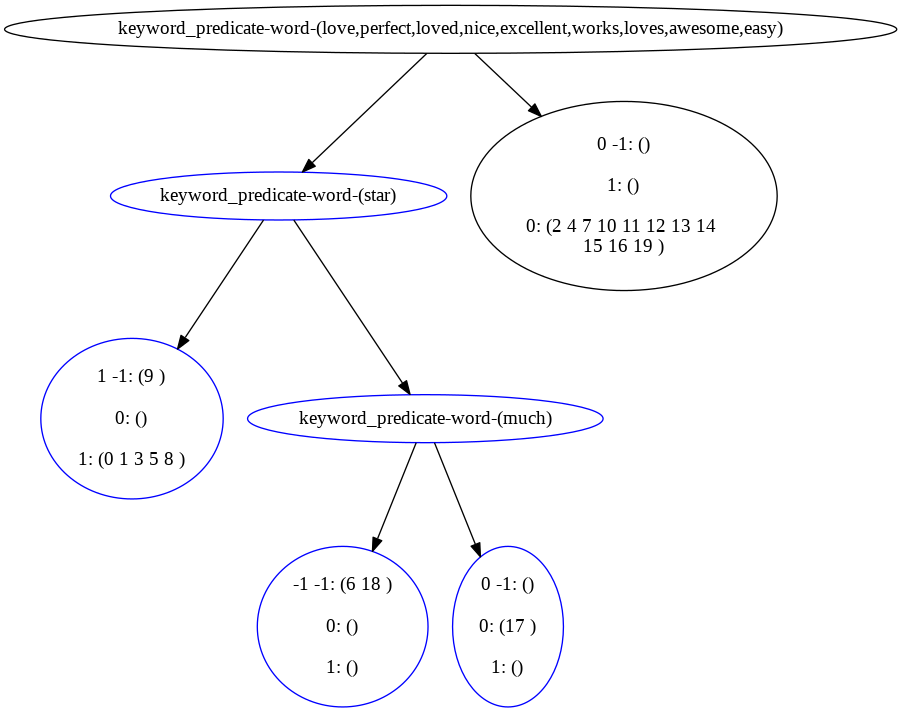

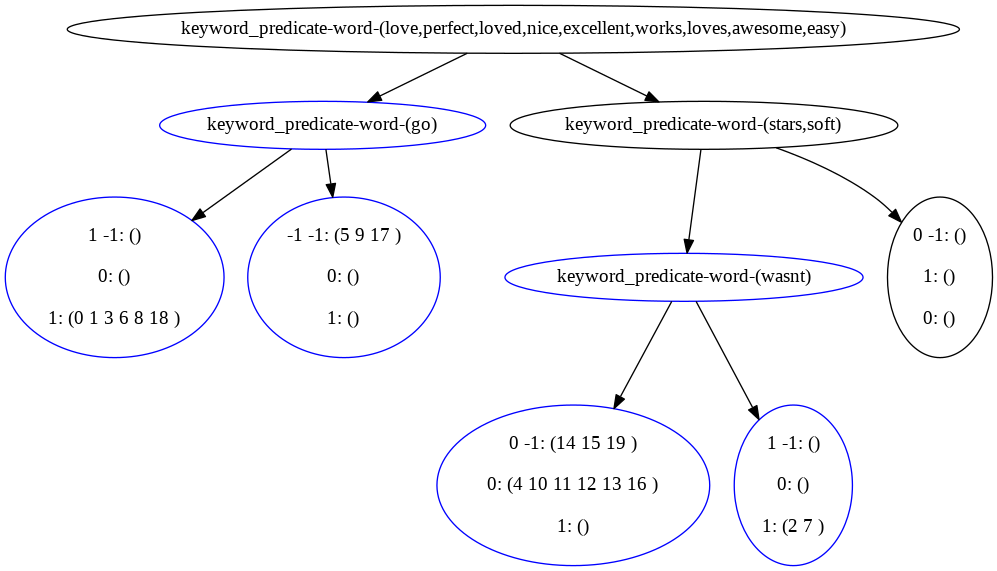

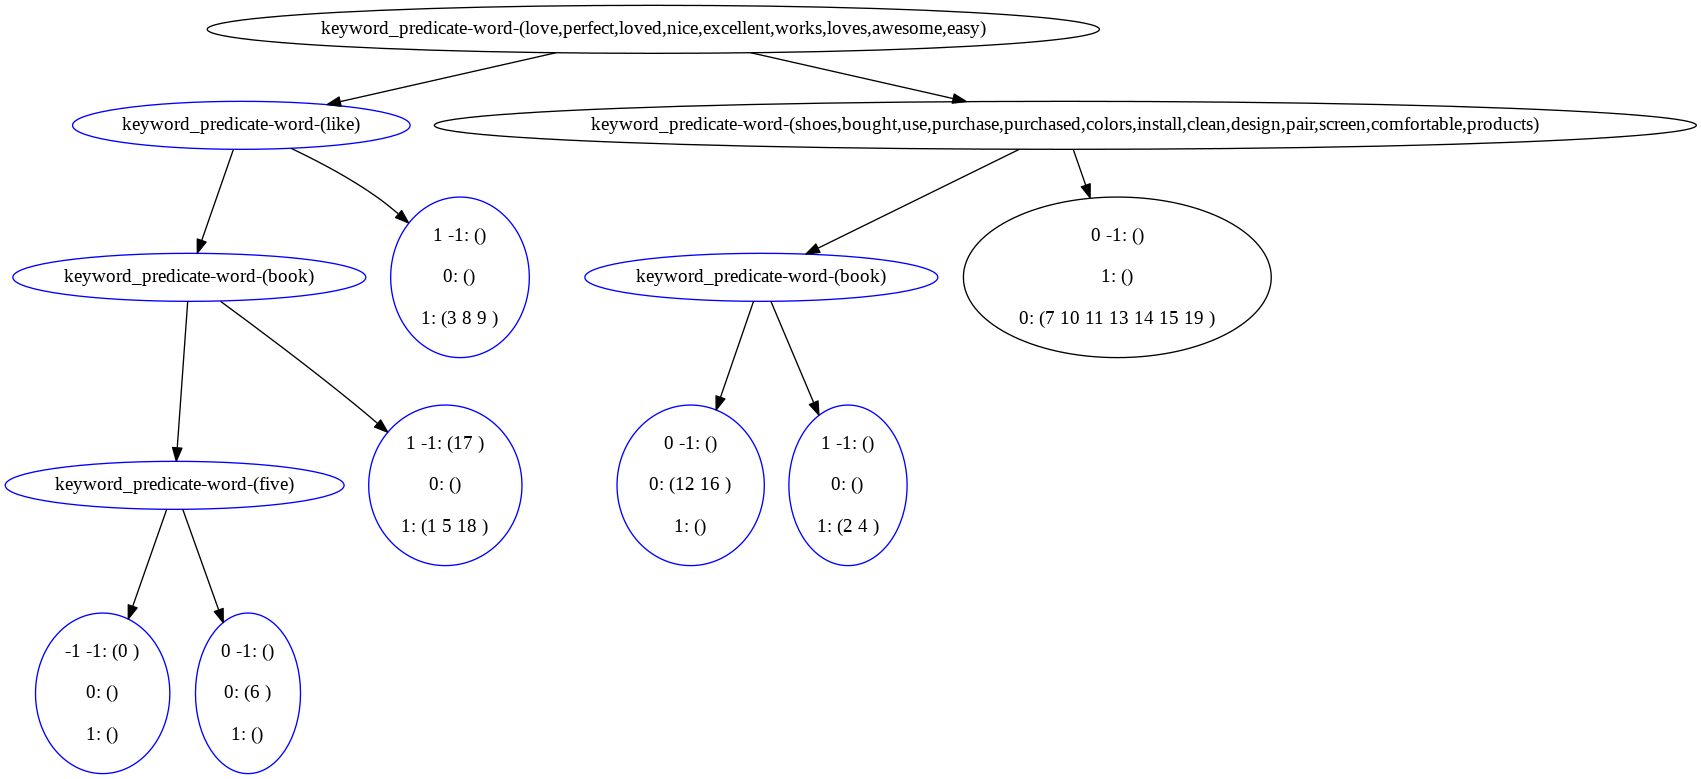

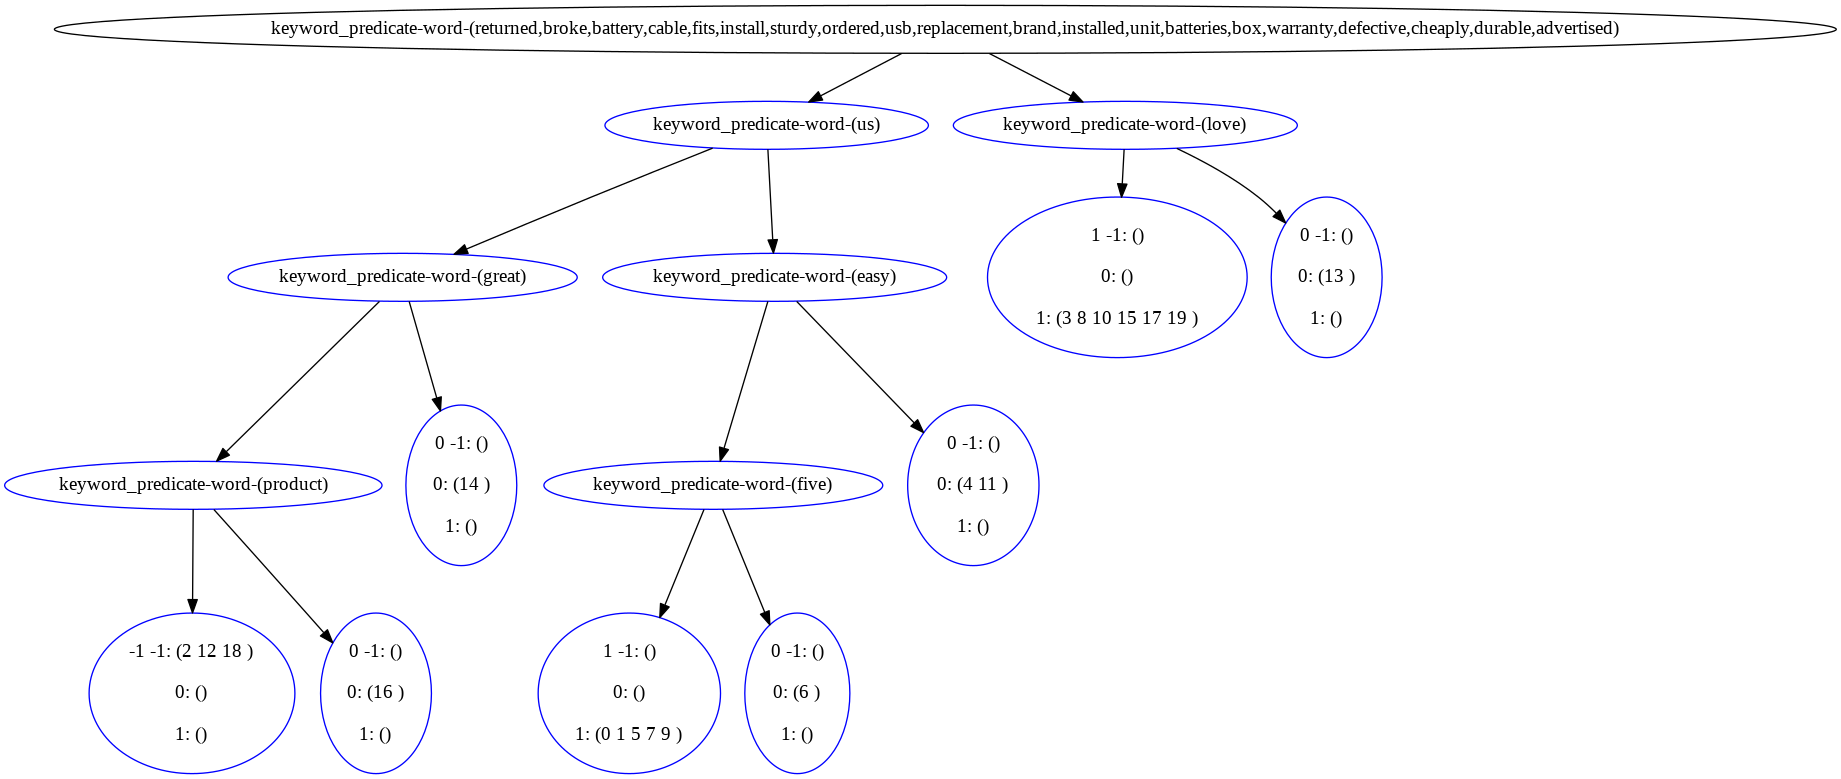

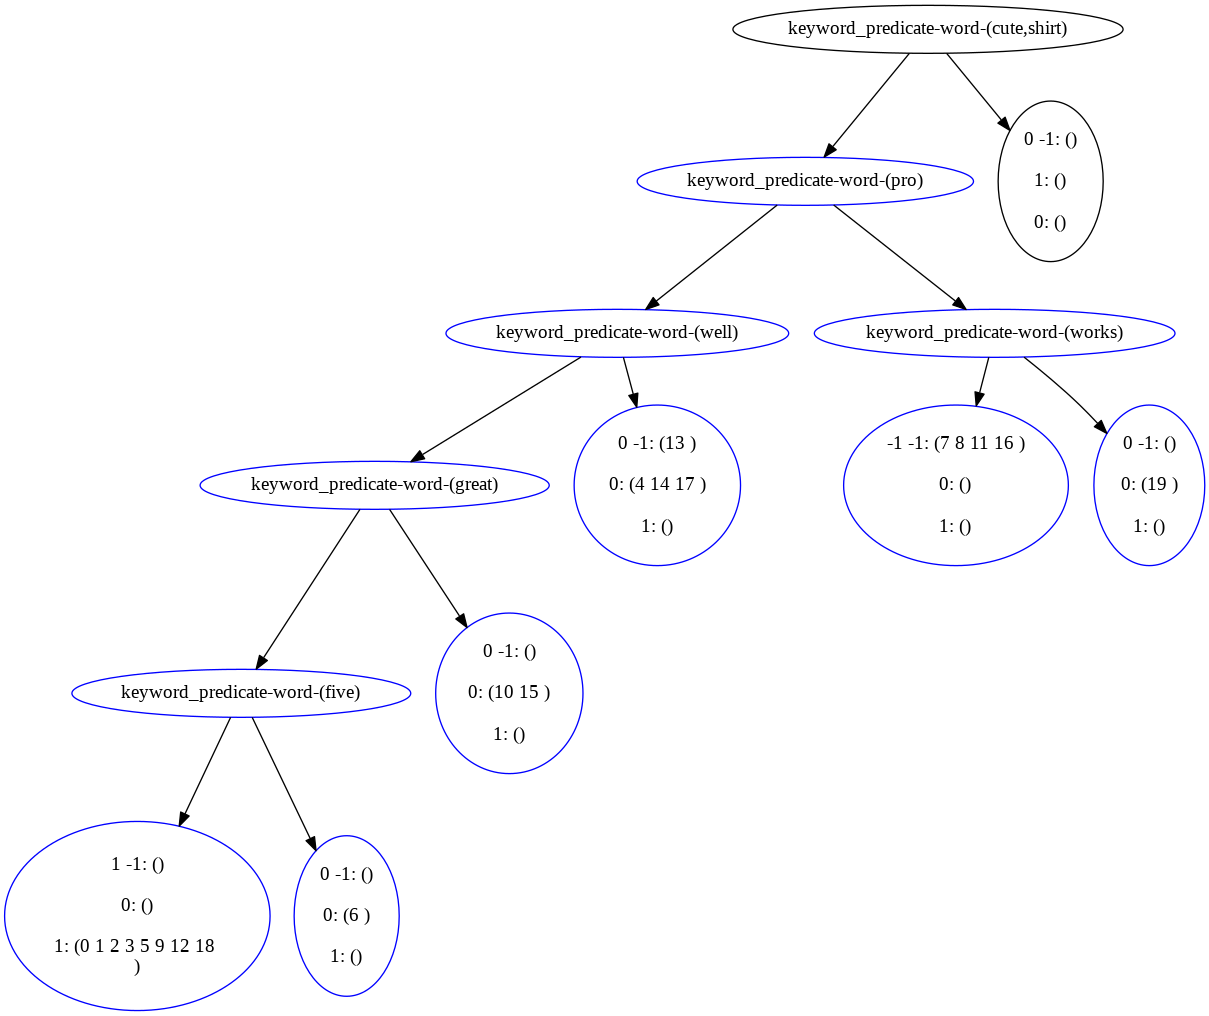

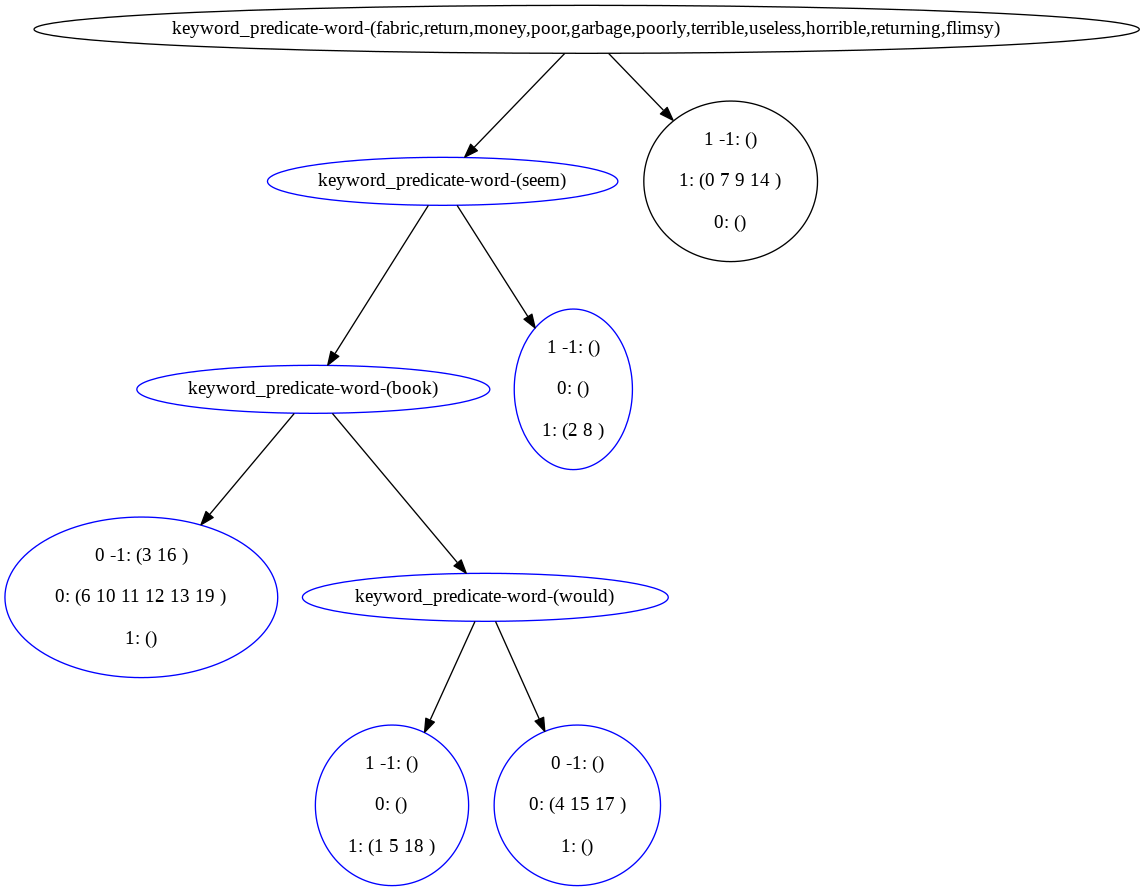

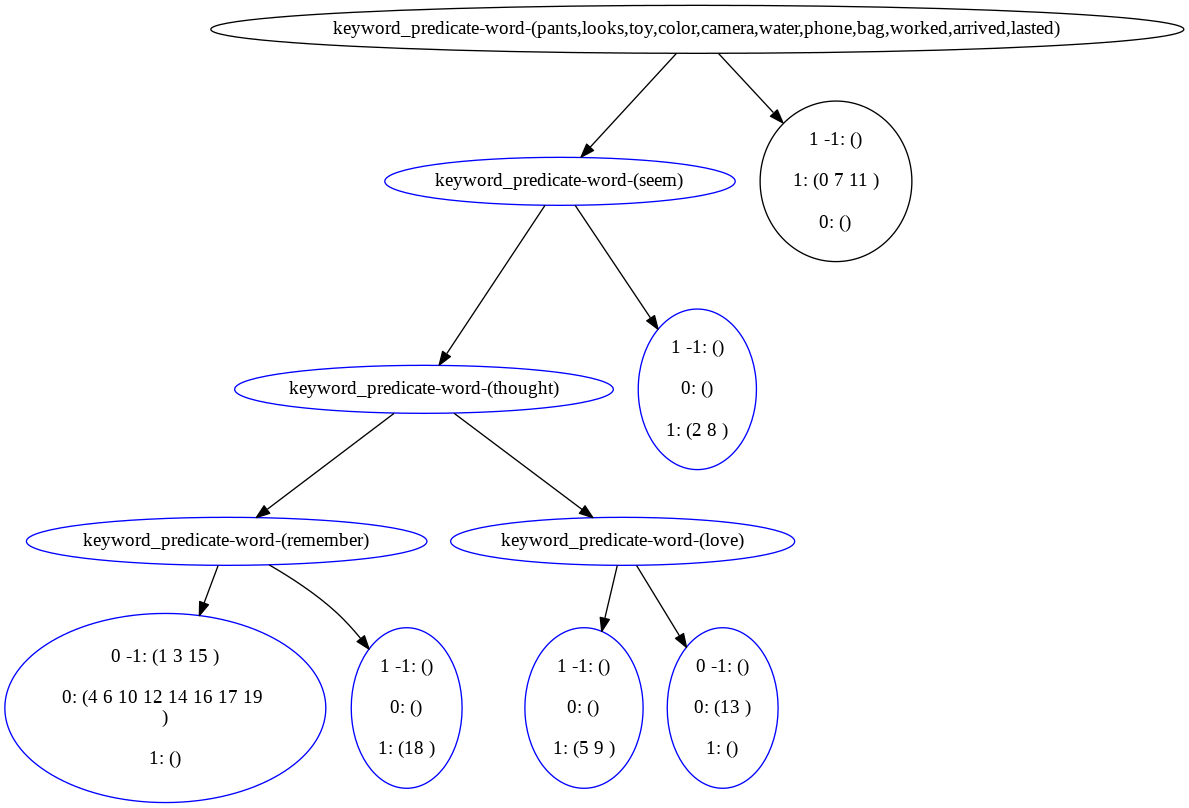

In [65]:
for r in rulecleaner_input['fix_details']:
    dot_string = rulecleaner_input['fix_details'][r]['rule'].gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [47]:
rule_cleaner_refined_funcs = [f.gen_label_rule() for f in rule_cleaner_refined_trees]

In [48]:
new_df_sentences_filtered_from_rc, new_correct_preds_by_snorkel_from_rc, new_wrong_preds_by_snorkel_from_rc, new_filtered_vectors_from_rc, new_correct_predictions_from_rc, \
    new_incorrect_predictions_from_rc, new_global_accuracy_from_rc, new_global_accuracy_on_valid_from_rc = run_snorkel_with_funcs(dataset_name='amazon', funcs=rule_cleaner_refined_funcs, conn=conn)


/tmp/ipykernel_12376/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:48:25,123 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:48:25,183 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 756.43epoch/s]
INFO 2024-10-17 21:48:25,850 [label_model.py:fit:977] Finished Training



        out of 199591 sentences, 199591 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 45464 wrong predictions, 

        accuracy = 0.7722141779939977 
    


In [49]:
new_global_accuracy_from_rc

0.7722141779939977

In [53]:
confirm_cids = user_df[0][user_df[0]['expected_label']==user_df[0]['model_pred']]['cid'].to_list()
complaint_cids = user_df[0][user_df[0]['expected_label']!=user_df[0]['model_pred']]['cid'].to_list()

In [54]:
confirm_cids

[167090, 176141, 173611, 138334, 40783, 135553, 60733, 172837, 130739, 119547]

In [55]:
complaint_cids

[28335, 3738, 45081, 60698, 20042, 77474, 100402, 104877, 18346, 96193]

In [56]:
# chat gpt confirm preserv and fix rate
df_confirms_after_fix = new_df_sentences_filtered[(new_df_sentences_filtered['cid'].isin(confirm_cids))]
df_complaints_after_fix = new_df_sentences_filtered[(new_df_sentences_filtered['cid'].isin(complaint_cids))]

confirm_preserv_rate = len(df_confirms_after_fix[df_confirms_after_fix['expected_label']==df_confirms_after_fix['model_pred']])/len(df_confirms_after_fix)
complain_fix_rate = len(df_complaints_after_fix[df_complaints_after_fix['expected_label']==df_complaints_after_fix['model_pred']])/len(df_complaints_after_fix)


In [57]:
confirm_preserv_rate

0.9

In [58]:
complain_fix_rate

0.5

In [62]:
# rc confirm preserv and fix rate
df_confirms_after_fix = new_df_sentences_filtered_from_rc[(new_df_sentences_filtered_from_rc['cid'].isin(confirm_cids))]
df_complaints_after_fix = new_df_sentences_filtered_from_rc[(new_df_sentences_filtered_from_rc['cid'].isin(complaint_cids))]

confirm_preserv_rate_rc = len(df_confirms_after_fix[df_confirms_after_fix['expected_label']==df_confirms_after_fix['model_pred']])/len(df_confirms_after_fix)
complain_fix_rate_rc = len(df_complaints_after_fix[df_complaints_after_fix['expected_label']==df_complaints_after_fix['model_pred']])/len(df_complaints_after_fix)


In [63]:
confirm_preserv_rate_rc

1.0

In [64]:
complain_fix_rate_rc

1.0

In [67]:
rulecleaner_input['fix_details']['original_6']['user_input']

text  \
93611                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 dont waste your money you are better off buying a large glass vase than using this cheap tank the tank doesnt filter the water huge waste of money   
100609                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       such an outrageous plot i dont mind a twist in the plot but these twists and turns are so outrageous this is the second book that i have read from this author and it has the same type of twist which all fell short and rushed i think this will be the last book i read from this author   
98687                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              tell me that esther wasnt really this boring  what an incredible let down this video was i was hoping to hear some mysteries revealed that have swirled around the bibles book of esther nothing new here it seemed that the narrative had so little to offer that it often repeated itself very boring stuff i love a good documentary thats chocked full of interesting facts this video doesnt even come near as much as i like jean simmons i cant recommend this video to anyone   
71266                                                                                                                                                                                                                                                                                                                                                               